In [1]:
# Standard Library Imports
import os
import sys
from importlib import reload
from functools import partial
from enum import Enum
from typing import NamedTuple
from time import sleep

# Third-Party Library Imports
import numpy as np
from numpy.typing import ArrayLike
import pandas as pd
import xarray as xr
from scipy.stats import spearmanr

# Plotting imports
import hvplot.xarray
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib import ticker as mticker
import matplotlib.gridspec as gridspec
import matplotlib.colors as mcolors
import seaborn as sns
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# My imports
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts'))
sys.path.append(os.path.join(os.getcwd(), 'Documents', 'time_of_emergene_drafts', 'src'))

import utils
import plotting_utils
import climate_utils
import stats
import time_of_emrgence_calc as toe
import toe_constants as toe_const

# Suppress Warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', message="p-value floored: true value smaller than 0.001")
warnings.filterwarnings('ignore', message="p-value capped: true value larger than 0.25")

Matplotlib created a temporary config/cache directory at /jobfs/115971280.gadi-pbs/matplotlib-anr651ml because the default path (/home/563/ab2313/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
# client.close()

In [3]:
# client.cluster.scale(6)

In [4]:
from dask.distributed import Client
client = Client(threads_per_worker=1, n_workers=12) #n_workers=2
# Scale the client to have n workers workers
# client.cluster.scale(28)
client

 - State start
 - Found stale lock file and directory '/jobfs/115971280.gadi-pbs/dask-scratch-space/scheduler-trwuoae6', purging
 -   Scheduler at:     tcp://127.0.0.1:34429
 -   dashboard at:         /proxy/8787/status
 - Registering Worker plugin shuffle
 -         Start Nanny at: 'tcp://127.0.0.1:44411'
 -         Start Nanny at: 'tcp://127.0.0.1:45057'
 - Register worker <WorkerState 'tcp://127.0.0.1:33331', name: 1, status: init, memory: 0, processing: 0>
 - Starting worker compute stream, tcp://127.0.0.1:33331
 - Starting established connection to tcp://127.0.0.1:39684
 - Register worker <WorkerState 'tcp://127.0.0.1:42521', name: 0, status: init, memory: 0, processing: 0>
 - Starting worker compute stream, tcp://127.0.0.1:42521
 - Starting established connection to tcp://127.0.0.1:39676
 - Receive client connection: Client-336c5714-14d7-11ef-997b-000007a9fe80
 - Starting established connection to tcp://127.0.0.1:39686


<Client: 'tcp://127.0.0.1:34429' processes=2 threads=2, memory=251.18 GiB>

In [5]:
xr.set_options(display_expand_attrs=False)
xr.set_options(display_expand_data=True)
np.set_printoptions(precision=2, suppress=True, edgeitems=1)

In [6]:
ROOT_DIR = '/g/data/w40/ab2313/PhD/time_of_emergence'
os.listdir(os.path.join(ROOT_DIR, 'best'))

['Complete_TAVG_LatLong1.nc',
 'best_mask_old.zarr',
 'best_mask.zarr',
 'Land_and_Ocean_LatLong1_time_chunk.zarr',
 'Land_and_Ocean_LatLong1.zarr',
 'Land_and_Ocean_LatLong1.nc',
 '.ipynb_checkpoints']

In [7]:
# chunk_size = {'time': len(best_ds.time.values), 'lat':90, 'lon': 120}  # Chunking in time
# best_ds = best_ds.rename({'latitude':'lat', 'longitude': 'lon|'})
# best_ds = best_ds.chunk(chunk_size)

# best_ds.to_zarr(os.path.join(ROOT_DIR, 'best', 'Land_and_Ocean_LatLong1_time_chunk.zarr'), mode='w',
#            encoding={'temperature': {'chunks': (chunk_size['time'], chunk_size['lat'], chunk_size['lon'])}})

In [8]:
best_ds_raw = xr.open_dataset(os.path.join(ROOT_DIR, 'best', 'Land_and_Ocean_LatLong1_time_chunk.zarr'), 
                    chunks={'time':-1, 'latitude': 90, 'longitude': 120},
                    use_cftime=True)

best_ds_raw['time'] = xr.cftime_range(start='1850-01-01', freq='M', periods=len(best_ds_raw.time.values))
best_ds = best_ds_raw.copy(deep=True)['temperature']
best_ds = best_ds.resample(time='Y').mean()
best_ds = best_ds.compute()

0.3.0


In [9]:
# Create a data set for the base period used as the pre-industrial climate 
start_end_tuple = (1850, 1900)#(1900, 1931)

base_period_ds = best_ds.where(best_ds.time.dt.year.isin(np.arange(*start_end_tuple)), drop=True)
base_period_ds

<xarray.DataArray 'temperature' (time: 50, lat: 180, lon: 360)>
array([[[  nan, ...,   nan],
        ...,
        [  nan, ...,   nan]],

       ...,

       [[  nan, ...,   nan],
        ...,
        [-0.03, ..., -0.03]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1850-12-31 00:00:00 ... 1899-12-31 00:00:00
Attributes: (5)

In [10]:
base_period_ds_count = base_period_ds.count(dim='time')

In [11]:
# Create a mask that removes any grid celss where there are less than 40 point in the base period
data_availability_mask = xr.where(base_period_ds_count>=40, 1, 0)
data_availability_mask

<xarray.DataArray 'temperature' (lat: 180, lon: 360)>
array([[0, ..., 0],
       ...,
       [0, ..., 0]])
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5

In [12]:
# Apply the mask to both the base period and the full dataset
best_ds = best_ds.where(data_availability_mask)
base_period_ds = base_period_ds.where(data_availability_mask)

In [13]:
# Resetting the anomlies to 1850
best_ds = best_ds - base_period_ds.mean(dim='time')
base_period_ds = base_period_ds - base_period_ds.mean(dim='time')

In [14]:
land_mask_ds = xr.open_dataarray('/g/data/w40/ab2313/PhD/time_of_emergence/best/best_mask.zarr')
land_mask_ds

<xarray.DataArray 'land_mask' (lat: 180, lon: 360)>
[64800 values with dtype=float64]
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Attributes: (5)

# P-value Methods

1d Array Method <br>

This method comapes starting from the begging and looops through. The nans are added to the end so the length matches

In [15]:
# P-value methods works better with a large cluster.
# Small chunks with large computation
client.cluster.scale(28)
sleep(7)

 -         Start Nanny at: 'tcp://127.0.0.1:34941'
 -         Start Nanny at: 'tcp://127.0.0.1:38437'
 -         Start Nanny at: 'tcp://127.0.0.1:41229'
 -         Start Nanny at: 'tcp://127.0.0.1:39255'
 -         Start Nanny at: 'tcp://127.0.0.1:39273'
 -         Start Nanny at: 'tcp://127.0.0.1:39577'
 -         Start Nanny at: 'tcp://127.0.0.1:40631'
 -         Start Nanny at: 'tcp://127.0.0.1:33301'
 -         Start Nanny at: 'tcp://127.0.0.1:33327'
 -         Start Nanny at: 'tcp://127.0.0.1:33395'
 -         Start Nanny at: 'tcp://127.0.0.1:44703'
 -         Start Nanny at: 'tcp://127.0.0.1:46825'
 -         Start Nanny at: 'tcp://127.0.0.1:40961'
 -         Start Nanny at: 'tcp://127.0.0.1:45319'
 -         Start Nanny at: 'tcp://127.0.0.1:37001'
 -         Start Nanny at: 'tcp://127.0.0.1:39863'
 -         Start Nanny at: 'tcp://127.0.0.1:43445'
 -         Start Nanny at: 'tcp://127.0.0.1:36619'
 -         Start Nanny at: 'tcp://127.0.0.1:32913'
 -         Start Nanny at: 'tcp

In [16]:
# Try with a belt latittude and longitude
#.sel(lat=slice(-45, -35), lon=slice(135, 160)) # {'lat':5, 'lon':5, 'time':-1}

In [17]:
window = 20

In [18]:
CHUNKS_FOR_PVALUE_TESTS =  {'lat':30, 'lon':30, 'time':-1}

In [19]:
# Creting new datasets that has windown dimnsion for the rolling calculation
best_ds_window = (best_ds
                  .chunk(CHUNKS_FOR_PVALUE_TESTS)
                  .rolling(time=window, center=True, min_periods=window)
                  .construct('window_dim')
                  .persist()) 

base_period_window_ds = (base_period_ds
                         .chunk(CHUNKS_FOR_PVALUE_TESTS)
                         .rename({'time':'window_dim'})
                         .persist())

In [20]:
best_ds_window

<xarray.DataArray 'temperature' (time: 175, lat: 180, lon: 360, window_dim: 20)>
dask.array<sliding_window_view, shape=(175, 180, 360, 20), dtype=float32, chunksize=(174, 30, 30, 20), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00
Dimensions without coordinates: window_dim

In [21]:
base_period_window_ds

<xarray.DataArray 'temperature' (window_dim: 50, lat: 180, lon: 360)>
dask.array<xarray-<this-array>, shape=(50, 180, 360), dtype=float32, chunksize=(50, 30, 30), chunktype=numpy.ndarray>
Coordinates:
  * lat         (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon         (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * window_dim  (window_dim) object 1850-12-31 00:00:00 ... 1899-12-31 00:00:00

In [22]:
# The arguements needed for all of the calculations
rolling_window_kwargs = dict(
    input_core_dims=[['window_dim'], ['window_dim']],
    exclude_dims={'window_dim'},
    vectorize=True,
    dask='parallelized')

In [23]:
%%time
ttest_ds = xr.apply_ufunc(
        toe.return_ttest_pvalue,
        best_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

CPU times: user 1min 38s, sys: 13.5 s, total: 1min 51s
Wall time: 7min 7s


In [24]:
%%time
ks_ds = xr.apply_ufunc(
        toe.return_ks_pvalue,
        best_ds_window,
        base_period_window_ds,
    **rolling_window_kwargs
    ).compute()

CPU times: user 10.3 s, sys: 1.71 s, total: 12 s
Wall time: 56.6 s


In [25]:
# ks_2samp will perfom on all nan slices
ks_ds = ks_ds.where(data_availability_mask)

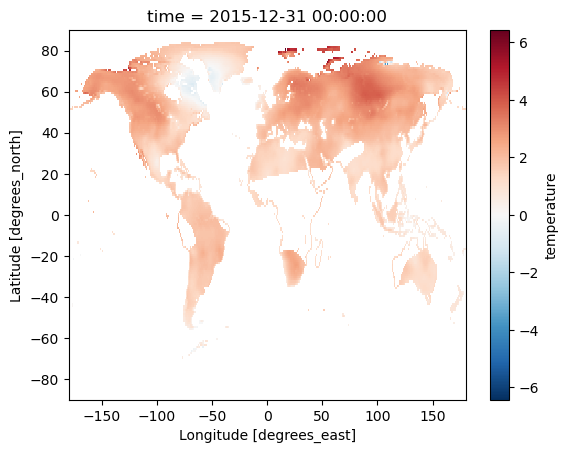

In [26]:
best_ds.where(land_mask_ds).isel(time=-10).plot()

In [27]:
anderson_ds = xr.apply_ufunc(
    toe.return_anderson_pvalue,
    best_ds_window,
    base_period_window_ds,
    output_dtypes=float, 
    **rolling_window_kwargs
    ).compute()

/home/563/ab2313/Documents/time_of_emergene_drafts/src/time_of_emrgence_calc.py:63: UserWarning: p-value floored: true value smaller than 0.001
  return anderson_ksamp([test_arr, base_arr]).pvalue
/home/563/ab2313/Documents/time_of_emergene_drafts/src/time_of_emrgence_calc.py:63: UserWarning: p-value floored: true value smaller than 0.001
  return anderson_ksamp([test_arr, base_arr]).pvalue
/home/563/ab2313/Documents/time_of_emergene_drafts/src/time_of_emrgence_calc.py:63: UserWarning: p-value floored: true value smaller than 0.001
  return anderson_ksamp([test_arr, base_arr]).pvalue
/home/563/ab2313/Documents/time_of_emergene_drafts/src/time_of_emrgence_calc.py:63: UserWarning: p-value floored: true value smaller than 0.001
  return anderson_ksamp([test_arr, base_arr]).pvalue
/home/563/ab2313/Documents/time_of_emergene_drafts/src/time_of_emrgence_calc.py:63: UserWarning: p-value floored: true value smaller than 0.001
  return anderson_ksamp([test_arr, base_arr]).pvalue
/home/563/ab231

## Verification that method works
Verifyting the abstracted (but faster) methods works by comparing to a single lat, lon point.

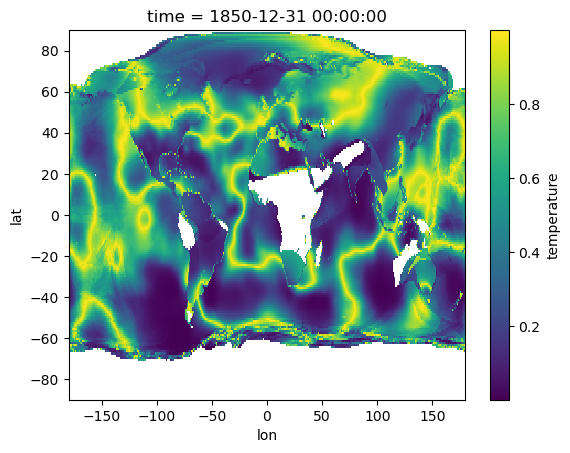

In [28]:
ttest_ds.isel(time=0).plot()

In [29]:
lat_lon_sp = dict(lat=-39, lon=145, method='nearest')

In [30]:
stats_test_1d_array_ttest = partial(
    toe.stats_test_1d_array, stats_func=toe.return_ttest_pvalue, window=window)

stats_test_1d_array_ks = partial(
    toe.stats_test_1d_array, stats_func=toe.return_ks_pvalue, window=window)

In [31]:
ttest_1d_1p = stats_test_1d_array_ttest(best_ds.sel(**lat_lon_sp))

In [32]:
ks_1d_1p = stats_test_1d_array_ks(best_ds.sel(**lat_lon_sp))

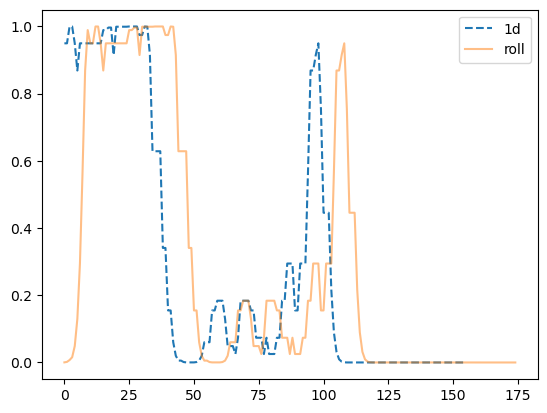

In [33]:
plt.plot(ks_1d_1p,label='1d', linestyle='--')
plt.plot(ks_ds.sel(**lat_lon_sp).values, label='roll', alpha=0.5)
plt.legend()

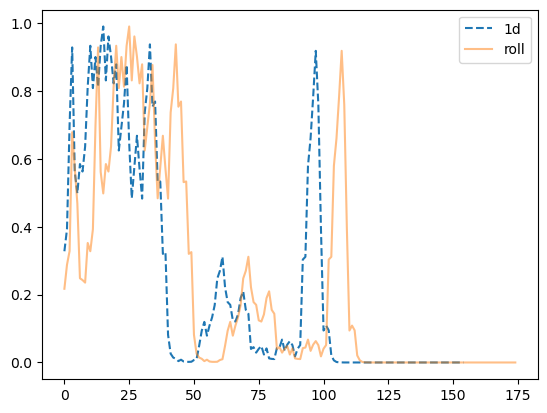

In [34]:
plt.plot(ttest_1d_1p,label='1d', linestyle='--')
plt.plot(ttest_ds.sel(**lat_lon_sp).values, label='roll', alpha=0.5)
plt.legend()

In [35]:
stats_test_1d_array_anderson = partial(
    toe.stats_test_1d_array, stats_func=toe.return_anderson_pvalue, window=window)

In [36]:
anderson_1d_1p = stats_test_1d_array_anderson(best_ds.sel(**lat_lon_sp))

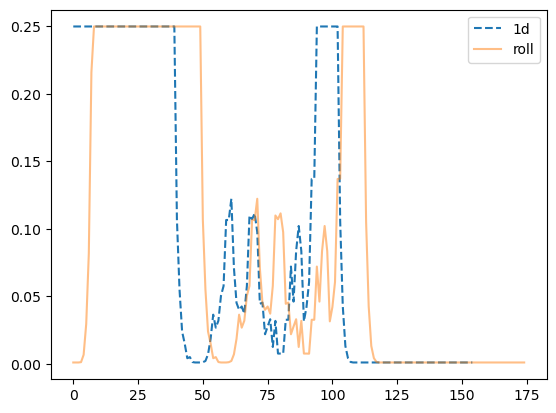

In [37]:
plt.plot(anderson_1d_1p, label='1d', linestyle='--')
plt.plot(anderson_ds.sel(**lat_lon_sp).values, label='roll', alpha=0.5)
plt.legend()

# Signal-to-Noise (hawkins)

In [38]:
# This amount of workers is no longer need
client.cluster.scale(5)
time.sleep(7)

 - Closing Nanny at 'tcp://127.0.0.1:39255'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:39273'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:39577'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:40631'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:33301'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:33327'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:33395'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:44703'. Reason: nanny-close
 - Nanny asking worker to close. Reason: nanny-close
 - Closing Nanny at 'tcp://127.0.0.1:46825'. Reason: nan

NameError: name 'time' is not defined

In [39]:
# Calculate the wegithed mean
best_ds_smean = climate_utils.weighted_lat_lon_mean(best_ds)
best_ds_smean

<xarray.DataArray 'temperature' (time: 175)>
array([-0.08, -0.01,  0.04,  0.02,  0.01,  0.03, -0.09, -0.21, -0.04,
        0.08, -0.07, -0.15, -0.22, -0.07, -0.02,  0.06,  0.1 ,  0.12,
        0.11,  0.04,  0.01, -0.  ,  0.02,  0.05, -0.04, -0.02, -0.03,
        0.34,  0.4 ,  0.09,  0.02,  0.12,  0.08,  0.01, -0.14, -0.12,
       -0.15, -0.17,  0.01,  0.13, -0.14,  0.  , -0.09, -0.08, -0.07,
        0.  ,  0.11,  0.09, -0.12,  0.04,  0.15,  0.07, -0.09, -0.18,
       -0.23, -0.04,  0.04, -0.11, -0.16, -0.23, -0.18, -0.2 , -0.12,
       -0.1 ,  0.06,  0.14, -0.08, -0.23, -0.05, -0.04,  0.07,  0.1 ,
        0.01,  0.05,  0.03,  0.09,  0.21,  0.1 ,  0.11, -0.06,  0.17,
        0.21,  0.17, -0.02,  0.13,  0.08,  0.14,  0.29,  0.29,  0.3 ,
        0.35,  0.31,  0.33,  0.4 ,  0.51,  0.38,  0.21,  0.25,  0.2 ,
        0.19,  0.12,  0.29,  0.36,  0.44,  0.24,  0.16,  0.09,  0.32,
        0.34,  0.31,  0.29,  0.34,  0.31,  0.33,  0.08,  0.18,  0.22,
        0.24,  0.19,  0.32,  0.26,  0.14,  0.24,  0.39,  0.18,  0.27,
        0.17,  0.49,  0.36,  0.46,  0.53,  0.6 ,  0.42,  0.58,  0.39,
        0.41,  0.46,  0.59,  0.62,  0.55,  0.71,  0.67,  0.5 ,  0.57,
        0.63,  0.76,  0.61,  0.81,  0.93,  0.72,  0.7 ,  0.84,  0.89,
        0.9 ,  0.83,  0.95,  0.92,  0.89,  0.81,  0.91,  1.  ,  0.87,
        0.93,  0.94,  1.02,  1.2 ,  1.28,  1.19,  1.09,  1.22,  1.27,
        1.14,  1.16,  1.47,  1.63], dtype=float32)
Coordinates:
  * time     (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00

In [40]:
# Get lowess filtered version
best_ds_smean_lowess = stats.trend_fit(best_ds_smean, method='LOWESS', lowess_window=41)

In [41]:
return_hawkins_signal_and_noise_partial = partial(toe.return_hawkins_signal_and_noise, gt=best_ds_smean_lowess.values)

In [42]:
%%time
ds_best_signal, ds_best_noise_series = xr.apply_ufunc(
    return_hawkins_signal_and_noise_partial,
    best_ds,
    input_core_dims=[['time']], 
    output_core_dims=[['time'], ['time']], 
    dask='parallelized', 
    vectorize=True
)

 - Event loop was unresponsive in Scheduler for 3.30s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
 - Event loop was unresponsive in Scheduler for 3.13s.  This is often caused by long-running GIL-holding functions or moving large chunks of data. This can cause timeouts and instability.
CPU times: user 8.29 s, sys: 1.37 s, total: 9.66 s
Wall time: 7.88 s


In [43]:
ds_best_noise = ds_best_noise_series.std(dim='time')

In [44]:
ds_best_sn = ds_best_signal/ds_best_noise

In [45]:
ds_best_sn

<xarray.DataArray 'temperature' (lat: 180, lon: 360, time: 175)>
array([[[nan, ..., nan],
        ...,
        [nan, ..., nan]],

       ...,

       [[nan, ..., nan],
        ...,
        [nan, ..., nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00

## Verification Plots

In [46]:
sel_dict = dict(lat=-38, lon=144, method='nearest')

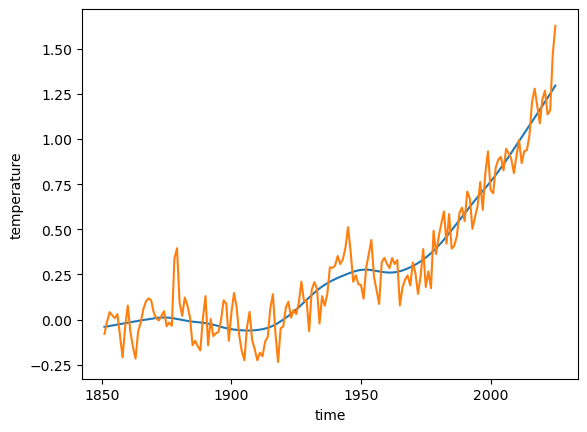

In [47]:
best_ds_smean_lowess.plot()
best_ds_smean.plot()

In [48]:
# Veriftying for a single point
signal_sp, noise_series_sp, reocnstructed_sp =\
    return_hawkins_signal_and_noise_partial(
        best_ds.sel(lat=-14, lon=-115, method='nearest').values,
        return_reconstruction=True)

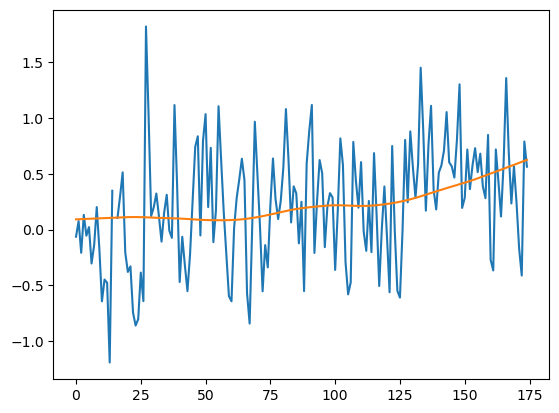

In [49]:
plt.plot(best_ds.sel(lat=-14, lon=-115, method='nearest').values)
plt.plot(reocnstructed_sp)

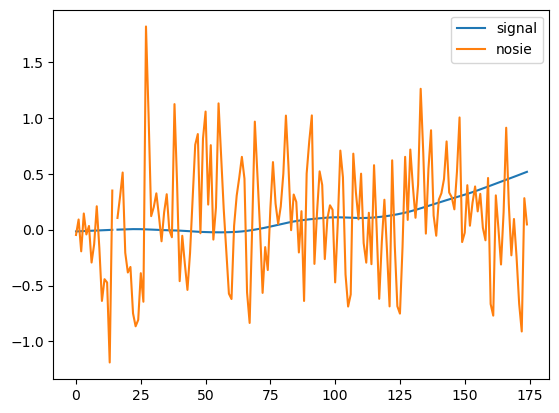

In [50]:
plt.plot(signal_sp, label='signal')
plt.plot(noise_series_sp, label='nosie')
plt.legend()

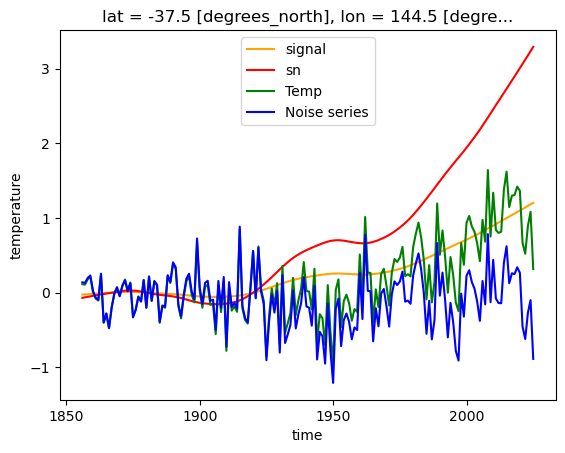

In [51]:
fig, ax1 = plt.subplots(1, 1)
ax2 = ax1#.twinx()
ds_best_signal.sel(**sel_dict).plot(ax=ax1, label='signal', color='orange')
ds_best_sn.sel(**sel_dict).plot(ax=ax1, label='sn', color='red')

best_ds.sel(**sel_dict).plot(ax=ax2, label='Temp', color='green')
ds_best_noise_series.sel(**sel_dict).plot(ax=ax2, color='blue', label='Noise series')

ax1.legend()
ax2.legend(loc='upper center')

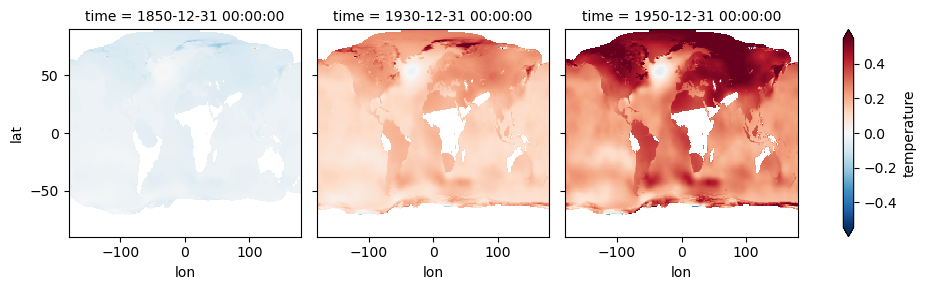

In [282]:
ds_best_signal.isel(time=[0, 80, 100]).plot(col='time', robust=True)

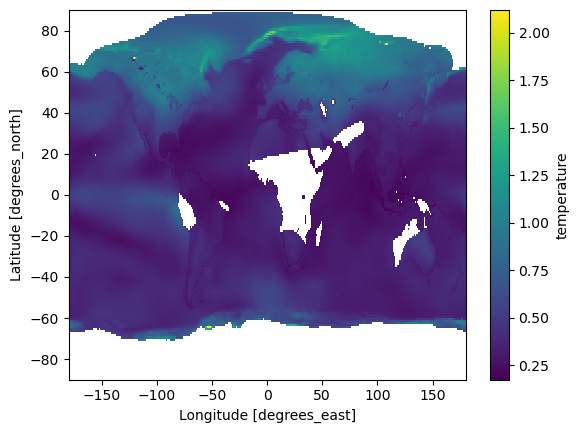

In [53]:
ds_best_noise.plot()

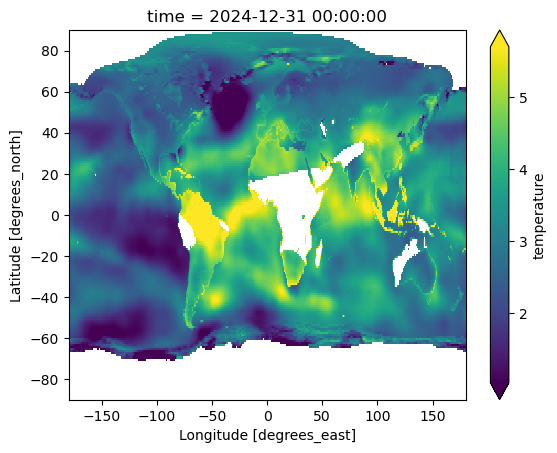

In [54]:
ds_best_sn.isel(time=-1).plot(robust=True)

In [55]:
ds_best_sn.isel(time=-1).hvplot(robust=True, cmap='RdBu')

 - robust option not found for image plot with bokeh; similar options include: ['rot']


:Image   [lon,lat]   (temperature)

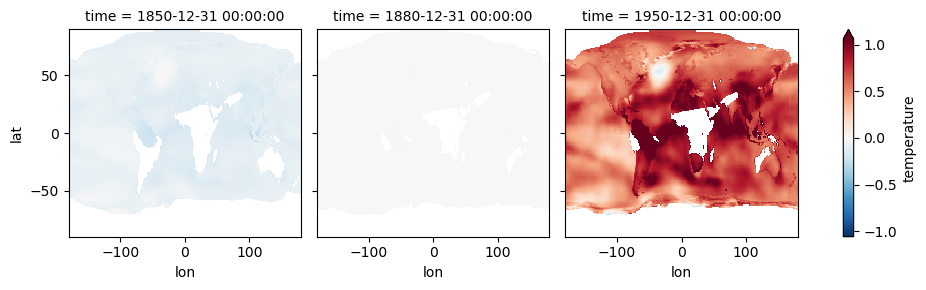

In [56]:
ds_best_sn.isel(time=[0, 30, 100]).plot(col='time', robust=True)

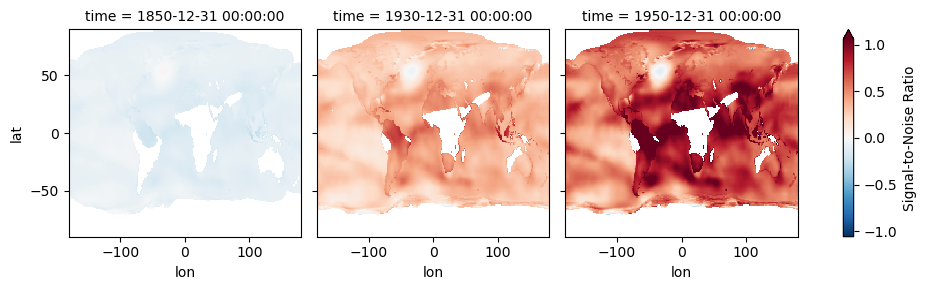

In [281]:
ds_best_sn.isel(time=[0, 80, 100]).plot(col='time', robust=True)

# Emergence Calculation

In [58]:
ds_best_sn.name = 'signal_to_noise'
ttest_ds.name = 'ttest'
ks_ds.name = 'ks'
anderson_ds.name = 'anderson'

In [59]:
# Set long name attributes for each variable
ds_best_sn.attrs['long_name'] = 'Signal-to-Noise Ratio'
ks_ds.attrs['long_name'] = 'Kolmogorov-Smirnov'
ttest_ds.attrs['long_name'] = 'T-Test'
anderson_ds.attrs['long_name'] = 'Anderson-Darling'

In [60]:
toe_metrics_ds = xr.merge([ks_ds, ttest_ds, anderson_ds, ds_best_sn])
toe_metrics_ds

<xarray.Dataset>
Dimensions:          (lat: 180, lon: 360, time: 175)
Coordinates:
  * lat              (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon              (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * time             (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00
Data variables:
    ks               (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    ttest            (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    anderson         (time, lat, lon) float64 nan nan nan nan ... nan nan nan
    signal_to_noise  (lat, lon, time) float32 nan nan nan nan ... nan nan nan
Attributes: (1)

In [61]:
# The rolling calculation ignores the minimum size. So need to slice half the window
# off on either side.
toe_metrics_ds = toe_metrics_ds.isel(time=slice(int(window/2), -int(window/2)))

In [62]:
PVALUE_THESHOLD1 = 0.01

In [63]:
# Finding when each test does not emerge
sn_does_not_emerge = (toe_metrics_ds['signal_to_noise'].isel(time=-1) <= 2)
ks_does_not_emerge = (toe_metrics_ds['ks'].isel(time=-1) >= PVALUE_THESHOLD1)
ttest_does_not_emerge = (toe_metrics_ds['ttest'].isel(time=-1) >= PVALUE_THESHOLD1)
anderson_does_not_emerge = (toe_metrics_ds['anderson'].isel(time=-1) >= PVALUE_THESHOLD1)

does_not_emerge_ds = xr.merge([sn_does_not_emerge, ks_does_not_emerge,ttest_does_not_emerge , anderson_does_not_emerge])

In [64]:
sn_toe_t1_ds = toe.get_permanent_exceedance(toe_metrics_ds['signal_to_noise'], threshold=1, comparison_func=np.greater_equal).expand_dims(threshold=[1])
sn_toe_t2_ds = toe.get_permanent_exceedance(toe_metrics_ds['signal_to_noise'], threshold=2, comparison_func=np.greater_equal).expand_dims(threshold=[2])
sn_toe_t3_ds = toe.get_permanent_exceedance(toe_metrics_ds['signal_to_noise'], threshold=3, comparison_func=np.greater_equal).expand_dims(threshold=[3])
sn_toe_t4_ds = toe.get_permanent_exceedance(toe_metrics_ds['signal_to_noise'], threshold=4, comparison_func=np.greater_equal).expand_dims(threshold=[4])

In [65]:
sn_does_not_emerge_t1 = (toe_metrics_ds['signal_to_noise'].isel(time=-1) <= 1).expand_dims(threshold=[1])
sn_does_not_emerge_t2 = (toe_metrics_ds['signal_to_noise'].isel(time=-1) <= 2).expand_dims(threshold=[2])
sn_does_not_emerge_t3 = (toe_metrics_ds['signal_to_noise'].isel(time=-1) <= 3).expand_dims(threshold=[3])
sn_does_not_emerge_t4 = (toe_metrics_ds['signal_to_noise'].isel(time=-1) <= 4).expand_dims(threshold=[4])

In [66]:
toe_sn_multi_thresh_ds = xr.concat([sn_toe_t1_ds, sn_toe_t2_ds, sn_toe_t3_ds, sn_toe_t4_ds], dim='threshold')

In [67]:
sn_does_not_emerge_multi_thresh_ds = xr.concat([sn_does_not_emerge_t1, sn_does_not_emerge_t2, sn_does_not_emerge_t3, sn_does_not_emerge_t4], dim='threshold')

In [68]:
# Find the year of permanent exceedance
sn_toe_ds = toe.get_permanent_exceedance(toe_metrics_ds['signal_to_noise'], threshold=2, comparison_func=np.greater_equal)
ks_toe_ds = toe.get_permanent_exceedance(toe_metrics_ds['ks'], threshold=PVALUE_THESHOLD1, comparison_func=np.less)
ttest_toe_ds = toe.get_permanent_exceedance(toe_metrics_ds['ttest'], threshold=PVALUE_THESHOLD1, comparison_func=np.less)
anderson_toe_ds = toe.get_permanent_exceedance(toe_metrics_ds['anderson'], threshold=PVALUE_THESHOLD1, comparison_func=np.less)

toe_ds = xr.merge([sn_toe_ds, ks_toe_ds,ttest_toe_ds , anderson_toe_ds])

In [69]:
difference_sn_ks_ds = toe_ds['signal_to_noise'] - toe_ds['ks']

In [70]:
reload(toe)

<module 'time_of_emrgence_calc' from '/home/563/ab2313/Documents/time_of_emergene_drafts/src/time_of_emrgence_calc.py'>

In [71]:
# Calculate an array of lat,lon, time, where there are 1s after emergenace has occured
# and zeros before emergence
# calculate_returned_binary_ds = partial(toe.calculate_returned_binary_ds, time_years=toe_metrics_ds.time.dt.year.values)

binary_emergence_ds = xr.apply_ufunc(
    toe.calculate_returned_binary_ds,
    toe_metrics_ds,
    toe_ds,
    toe_metrics_ds.time.dt.year.values,
    input_core_dims = [['time'], [], ['time']],
    output_core_dims=[['time']],
    vectorize=True,
    dask='parallelized'
)

In [72]:
# TODO: Somehow, non-zero and one values get in here. This will fix
# but should not be a long-term soluation
binary_emergence_ds = xr.where(binary_emergence_ds == 1, 1, 0)
binary_emergence_ds = binary_emergence_ds.where(data_availability_mask)

In [73]:
# Calculate the percent of points stable for different reiogns
emergence_time_series_ds = toe.calculate_percent_stable_for_regions(binary_emergence_ds, land_mask_ds,
                                                                   only_1s_ds = data_availability_mask, logginglevel='ERROR')

emergence_time_series_ds

<xarray.Dataset>
Dimensions:          (region: 10, time: 155)
Coordinates:
  * region           (region) object 'global' 'land' ... 'arctic' 'antarctic'
  * time             (time) object 1860-12-31 00:00:00 ... 2014-12-31 00:00:00
Data variables:
    ks               (region, time) float64 0.0 0.0 0.0 ... 65.18 67.08 67.39
    ttest            (region, time) float64 0.0 0.0 0.0 ... 74.57 77.06 78.37
    anderson         (region, time) float64 0.0 0.0 0.0 ... 67.01 67.97 68.94
    signal_to_noise  (region, time) float64 0.0 0.0 0.0 ... 10.09 11.43 13.75
Attributes: (10)

In [74]:
# Get the signal-to-noise value at the year that the KS test emerged

find_value_at_emergence_arg_partial = partial(toe.find_value_at_emergence_arg, time_years=toe_metrics_ds.time.dt.year.values)

sn_at_ks_emergence_ds = xr.apply_ufunc(
    find_value_at_emergence_arg_partial,
    toe_metrics_ds['signal_to_noise'],
    toe_ds['ks'],
    input_core_dims = [['time'], []],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized'
    
)

# Plotting

In [75]:
# Create a custom colormap with two colors: gray and transparent
colors = [(0, 0, 0, 0), (0.5, 0.5, 0.5, 1)]  # (R, G, B, Alpha)
cmap_binary = mcolors.LinearSegmentedColormap.from_list("binary_no_color", colors)

In [76]:
not_stable_kwargs = dict(add_colorbar=False, hatches=['', '////'], alpha=0, colors=None)

not_stable_kwargs2 = dict(cmap=cmap_binary, add_colorbar=False)

## Explorign Odd Patterns

In [77]:
time_indices = np.array([0, 50, 100, 150])

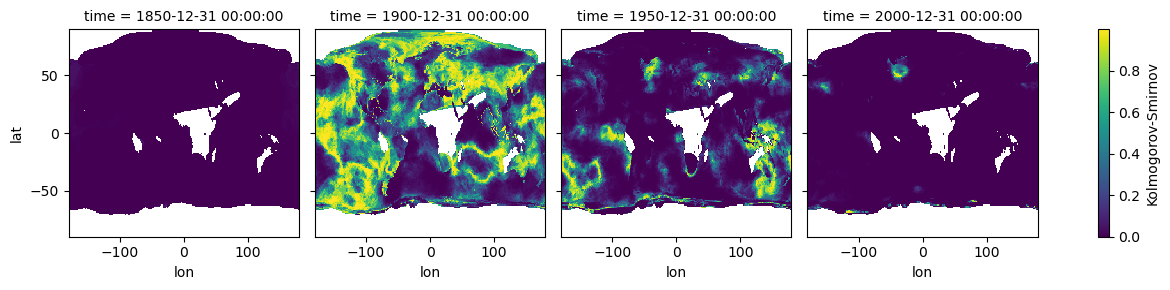

In [78]:
ks_ds.isel(time=time_indices).plot(col='time')

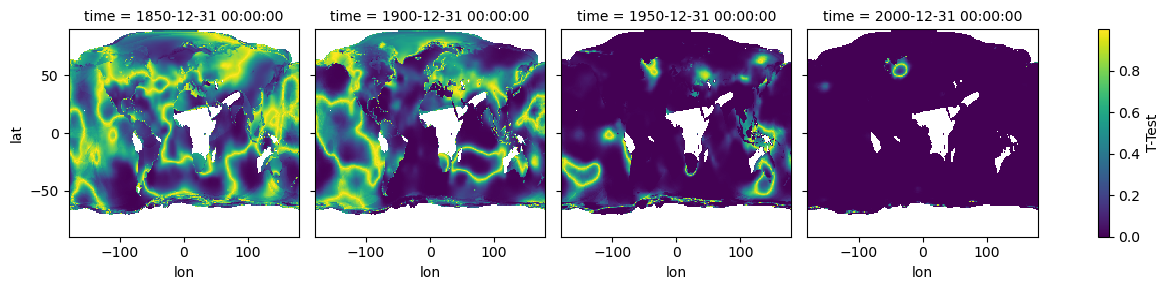

In [79]:
ttest_ds.isel(time=time_indices).plot(col='time')

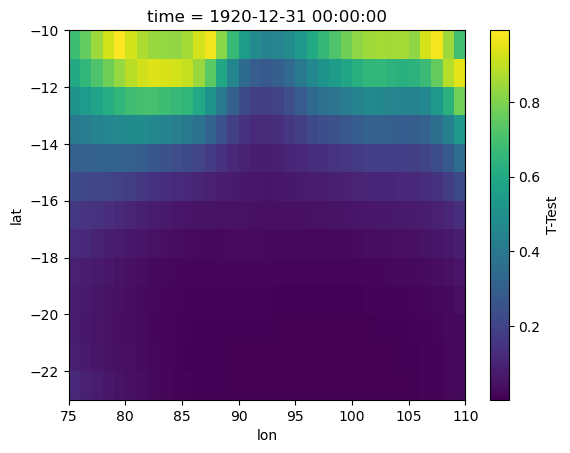

In [80]:
test_sample_ds = ttest_ds.isel(time=70).sel(lat=slice(-22.5, -10), lon=slice(75, 110))
test_sample_ds.plot()

In [81]:
min_lat_lon =\
    utils.find_nth_extreme_location(test_sample_ds, 'min',output_dtype='dict')
min_lat_lon

{'lat': -22.5, 'lon': 98.5}

In [82]:
max_lat_lon =\
    utils.find_nth_extreme_location(test_sample_ds, 'max',output_dtype='dict')
max_lat_lon

{'lat': -10.5, 'lon': 107.5}

In [83]:
min_time_series = best_ds.sel(**min_lat_lon)
max_time_series = best_ds.sel(**max_lat_lon)

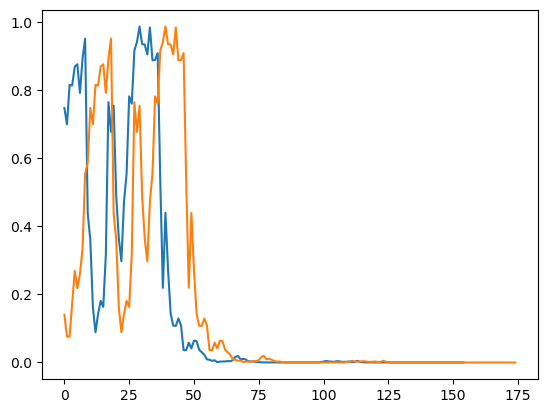

In [84]:
plt.plot(toe.stats_test_1d_array(min_time_series, stats_func=toe.return_ttest_pvalue))
plt.plot(ttest_ds.sel(**min_lat_lon).values)

In [85]:
min_series_pvals = xr.zeros_like(min_time_series) + toe.stats_test_1d_array(min_time_series, stats_func=toe.return_ttest_pvalue)
max_series_pvals = xr.zeros_like(max_time_series) + toe.stats_test_1d_array(max_time_series, stats_func=toe.return_ttest_pvalue)

In [86]:
def color_yaxis(axis, color, side='left'):
    if not isinstance(axis, list): axis = [axis]
    for ax in axis:
        ax.spines[side].set_color(color)
        ax.tick_params(axis='y', color=color, labelcolor=color)

Text(0, 0.5, 'Temperature\nAnomaly')

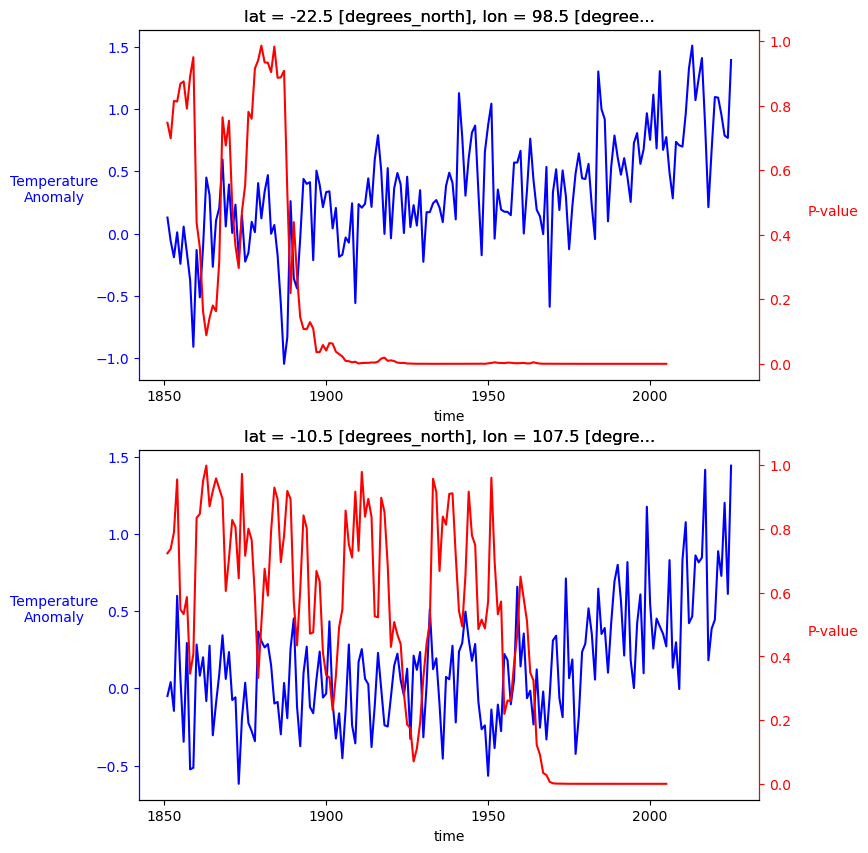

In [87]:
fig, (ax1, ax2) = plt.subplots(figsize=(8, 10), nrows=2, ncols=1)

ax1_twinx = ax1.twinx()
min_time_series.plot(ax=ax1, color='blue')
min_series_pvals.plot(ax=ax1_twinx, color='red')
color_yaxis([ax1, ax1_twinx], 'blue', 'left')
color_yaxis([ax1_twinx], 'red', 'right')
ax1_twinx.set_ylabel('P-value', c='red', rotation=0, labelpad=30)
ax1.set_ylabel('Temperature\nAnomaly', c='blue', rotation=0, labelpad=30)

ax2_twinx = ax2.twinx()
max_time_series.plot(ax=ax2, color='blue')
max_series_pvals.plot(ax=ax2_twinx, color='red')
color_yaxis([ax2, ax2_twinx], 'blue', 'left')
color_yaxis([ax2_twinx], 'red', 'right')
ax2_twinx.set_ylabel('P-value', c='red', rotation=0, labelpad=30)
ax2.set_ylabel('Temperature\nAnomaly', c='blue', rotation=0, labelpad=30)

In [88]:
import time_of_emergence_plots
import toe_constants as toe_const
import plotting_utils

In [89]:
toe_const.NAME_CONVERSION_DICT

{'signal_to_noise': 'Signal-to-Noise Ratio',
 'ks': 'Kolmogorov-Smirnov',
 'ttest': 'T-Test',
 'anderson': 'Anderson-Darling'}

In [90]:
long_names = list(toe_const.NAME_CONVERSION_DICT)

## Mask Experimentation

In [91]:
# grey_white_cmap = mcolors.LinearSegmentedColormap.from_list('grey_white_cmap',  [(1, 1, 1), (0.5, 0.5, 0.5)] , N=2)

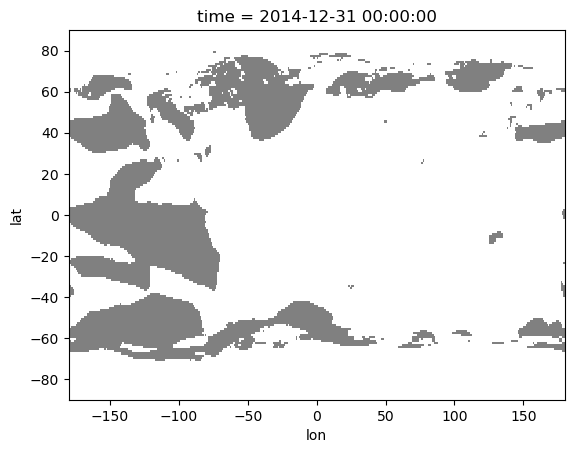

In [92]:
(does_not_emerge_ds['ks'] | does_not_emerge_ds['signal_to_noise']).plot(**not_stable_kwargs2)

Text(0.5, 1.0, 'Anderson')

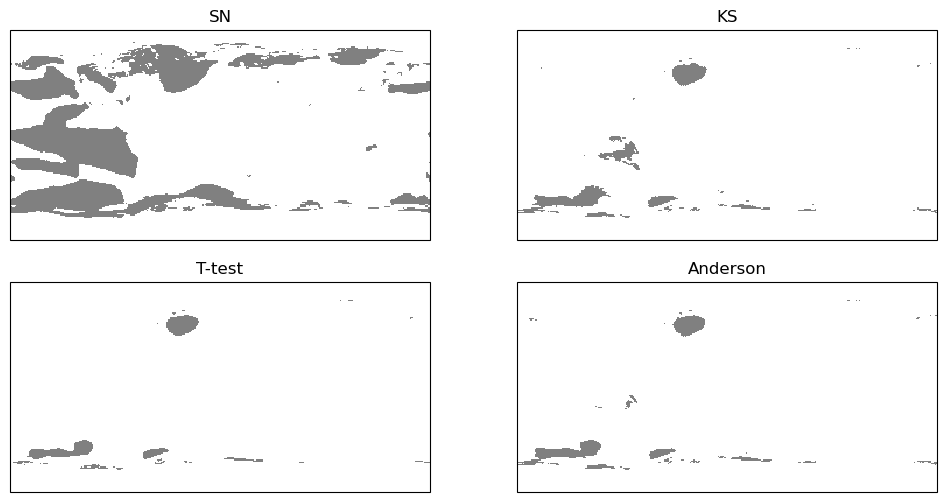

In [93]:
fig = plt.figure(figsize=(12, 6))
axes = [fig.add_subplot(2,2,i, projection=ccrs.PlateCarree()) for i in range(1,5)]

does_not_emerge_ds['signal_to_noise'].plot(ax=axes[0], **not_stable_kwargs2)
does_not_emerge_ds['ks'].plot(ax=axes[1], **not_stable_kwargs2)
does_not_emerge_ds['ttest'].plot(ax=axes[2], **not_stable_kwargs2)
does_not_emerge_ds['anderson'].plot(ax=axes[3], **not_stable_kwargs2)
axes[0].set_title('SN')
axes[1].set_title('KS')
axes[2].set_title('T-test')
axes[3].set_title('Anderson')

In [94]:
def hatch(ax, ds, **kwargs):
    LON, LAT = np.meshgrid(ds.lon.values, ds.lat.values)
    ax.contourf(LON, LAT, ds.values, **kwargs)

In [95]:
not_stable_kwargs = dict(add_colorbar=False, hatches=['', '////'], alpha=0, colors=None)

In [96]:
data_unavailability_mask = xr.where(data_availability_mask, False, True)

## Correlations and Distributions

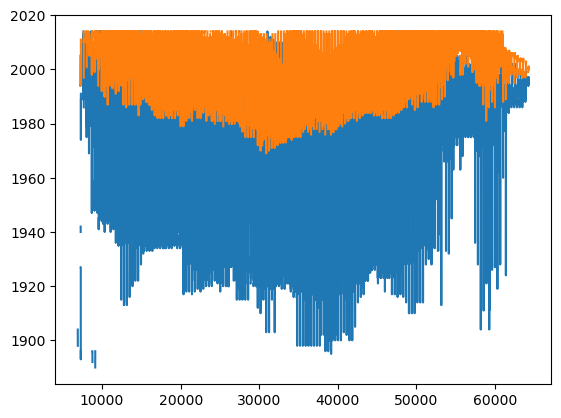

In [97]:
plt.plot(ks_toe_ds.values.flatten())
plt.plot(sn_toe_ds.values.flatten())

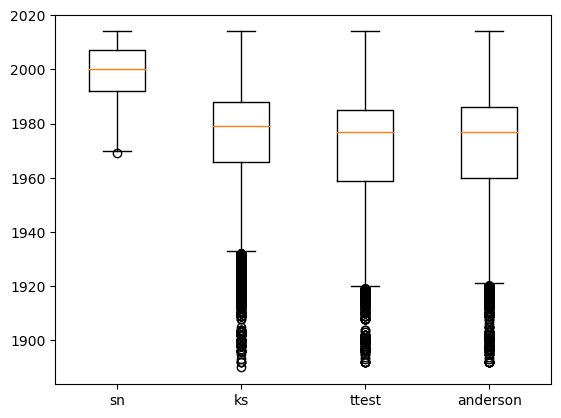

In [98]:
fig, ax = plt.subplots()

bins = np.arange(1900, 2025, 5)
ax.boxplot([toe_ds['signal_to_noise'].stack(latlon=['lat', 'lon']).dropna(dim='latlon').values.flatten(), 
            toe_ds['ks'].stack(latlon=['lat', 'lon']).dropna(dim='latlon').values.flatten(),
            toe_ds['ttest'].stack(latlon=['lat', 'lon']).dropna(dim='latlon').values.flatten(),
            toe_ds['anderson'].stack(latlon=['lat', 'lon']).dropna(dim='latlon').values.flatten()],
          labels=['sn', 'ks', 'ttest', 'anderson']);

In [99]:
xr.merge([toe_sn_multi_thresh_ds.sel(threshold=1), toe_ds[['ks', 'ttest', 'anderson']]])

<xarray.Dataset>
Dimensions:          (lat: 180, lon: 360)
Coordinates:
    threshold        int64 1
  * lat              (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon              (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Data variables:
    signal_to_noise  (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    ks               (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    ttest            (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
    anderson         (lat, lon) float64 nan nan nan nan nan ... nan nan nan nan
Attributes: (1)

In [100]:
test_pattern_correlation_sn1_df = toe.data_var_pattern_correlation_all_combs(xr.merge([toe_sn_multi_thresh_ds.sel(threshold=1), toe_ds[['ks', 'ttest', 'anderson']]]))

In [101]:
test_pattern_correlation_df = toe.data_var_pattern_correlation_all_combs(toe_ds)

In [102]:
test_pattern_correlation_sn1_df

signal_to_noise    ks  ttest  anderson
signal_to_noise              NaN   NaN    NaN       NaN
ks                          0.51   NaN    NaN       NaN
ttest                       0.48  0.89    NaN       NaN
anderson                    0.49  0.93   0.93       NaN

In [103]:
test_pattern_correlation_df

signal_to_noise    ks  ttest  anderson
signal_to_noise              NaN   NaN    NaN       NaN
ks                          0.47   NaN    NaN       NaN
ttest                       0.45  0.89    NaN       NaN
anderson                    0.46  0.93   0.93       NaN

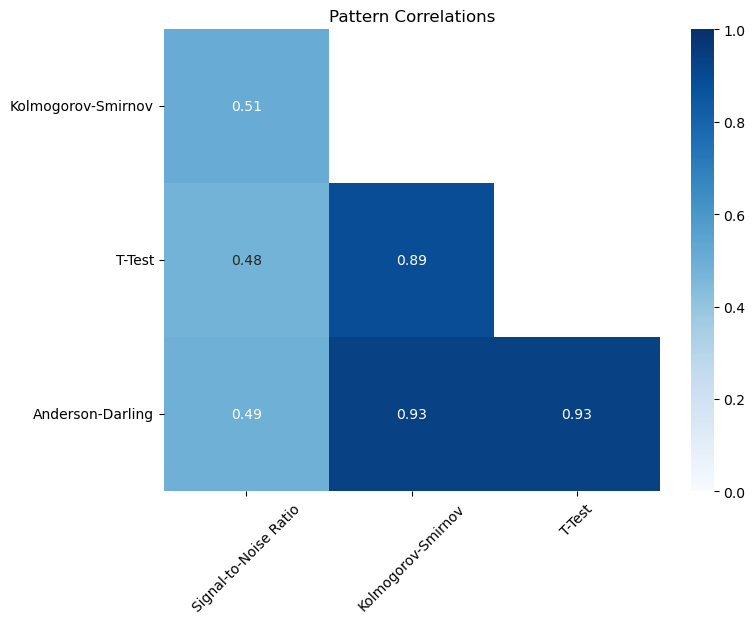

In [104]:
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(test_pattern_correlation_sn1_df.iloc[1:, :-1], annot=True, cmap='Blues', fmt='.2f', vmin=0, vmax=1)

# Change the ticks to long names
heatmap.set_xticklabels([toe_const.NAME_CONVERSION_DICT[text.get_text()] for text in heatmap.get_xticklabels()])
heatmap.set_yticklabels([toe_const.NAME_CONVERSION_DICT[text.get_text()] for text in heatmap.get_yticklabels()])

plt.title('Pattern Correlations');
plt.xticks(rotation=45);  # Rotate x-axis labels for better readability
plt.yticks(rotation=0) ;  # Keep y-axis labels horizontal

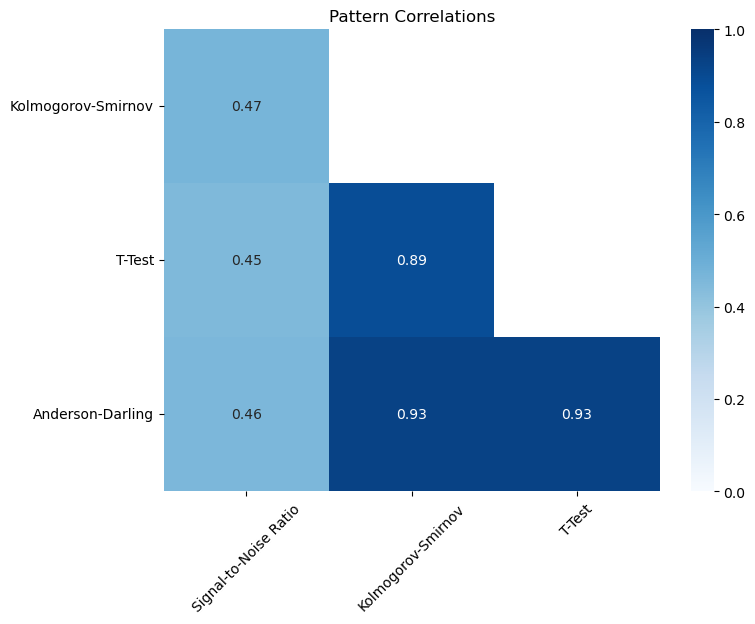

In [105]:
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(test_pattern_correlation_df.iloc[1:, :-1], annot=True, cmap='Blues', fmt='.2f', vmin=0, vmax=1)

# Change the ticks to long names
heatmap.set_xticklabels([toe_const.NAME_CONVERSION_DICT[text.get_text()] for text in heatmap.get_xticklabels()])
heatmap.set_yticklabels([toe_const.NAME_CONVERSION_DICT[text.get_text()] for text in heatmap.get_yticklabels()])

plt.title('Pattern Correlations');
plt.xticks(rotation=45);  # Rotate x-axis labels for better readability
plt.yticks(rotation=0) ;  # Keep y-axis labels horizontal

In [106]:
tests_used = list(toe_ds.data_vars)

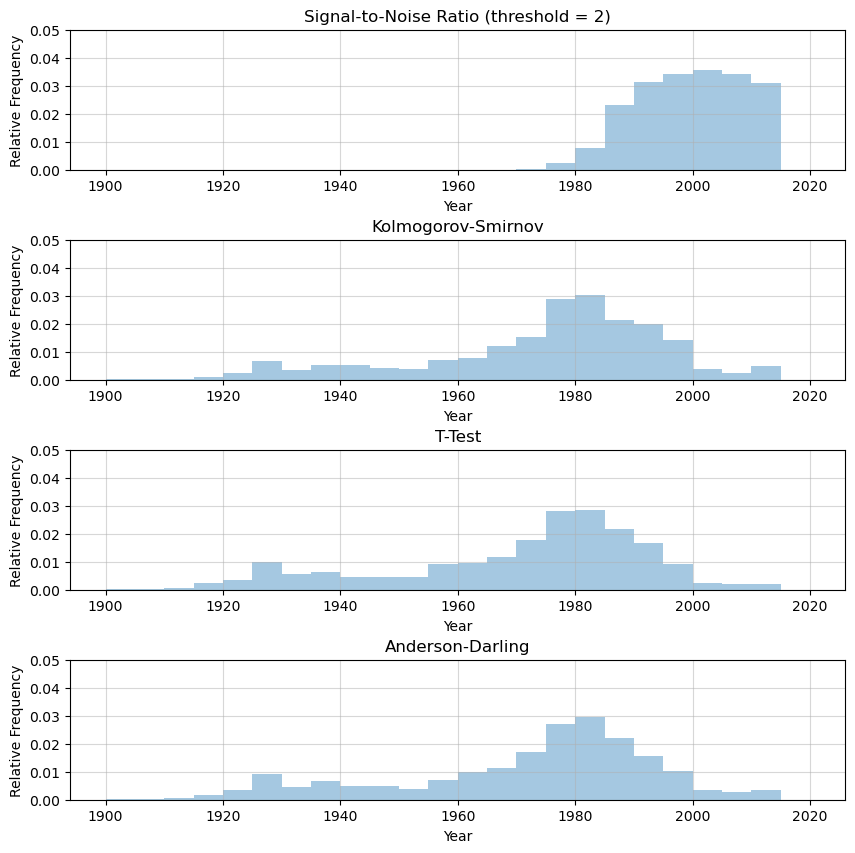

In [107]:
fig = plt.figure(figsize=(10, 10))

gs = gridspec.GridSpec(len(tests_used), 1, hspace=0.5)
axes = [fig.add_subplot(gs[i]) for i in range(len(tests_used))]

bins = np.arange(1900, 2025, 5)
for ax, test in zip(axes, tests_used):
    ax.grid(alpha=0.5, zorder=0)  # Set z-order for the grid lines
    ax.hist(toe_ds[test].values.flatten(), bins=bins, alpha=0.4, density=True)
    title = toe_ds[test].long_name 
    if test == 'signal_to_noise': title = f'{title} (threshold = 2)'
    ax.set_title(title)
    ax.set_xlabel('Year')
    ax.set_ylabel('Relative Frequency')
    ax.set_ylim([0, 0.05])
    


(0.0, 0.05)

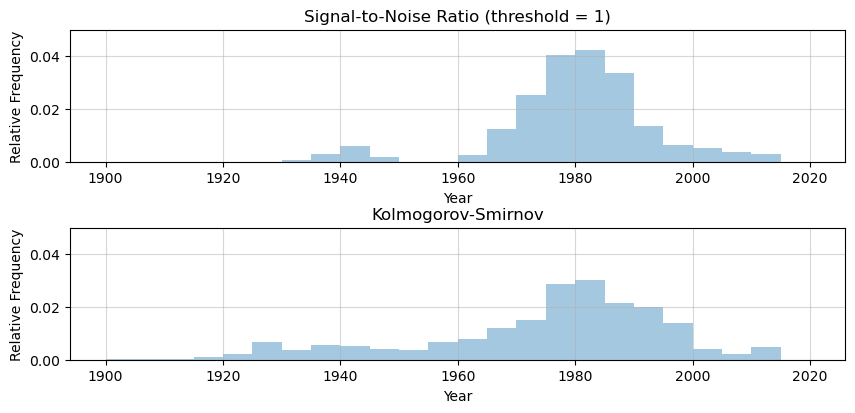

In [186]:
fig = plt.figure(figsize=(10, 12))

gs = gridspec.GridSpec(len(tests_used)+1, 1, hspace=0.5)
axes = [fig.add_subplot(gs[i]) for i in range(2)]

ax = axes[1]
test = 'ks'
ax.grid(alpha=0.5, zorder=0)  # Set z-order for the grid lines
ax.hist(toe_ds[test].values.flatten(), bins=bins, alpha=0.4, density=True)
title = toe_ds[test].long_name 
if test == 'signal_to_noise': title = f'{title} (threshold = 2)'
ax.set_title(title)
ax.set_xlabel('Year')
ax.set_ylabel('Relative Frequency')
ax.set_ylim([0, 0.05])
    
ax = axes[0]
ax.grid(alpha=0.5, zorder=0)
ax.hist(toe_sn_multi_thresh_ds.sel(threshold=1).values.flatten(), bins=bins, alpha=0.4, density=True);
title = toe_ds['signal_to_noise'].long_name
title = f'{title} (threshold = 1)'
ax.set_title(title)
ax.set_xlabel('Year')
ax.set_ylabel('Relative Frequency')
ax.set_ylim([0, 0.05])

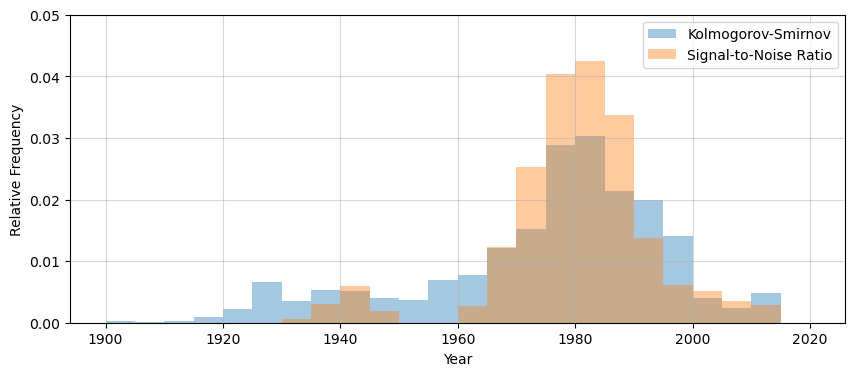

In [202]:
fig, ax = plt.subplots(figsize=(10, 4))


test = 'ks'
ax.grid(alpha=0.5, zorder=1)  # Set z-order for the grid lines
ax.hist(toe_ds[test].values.flatten(), bins=bins, alpha=0.4, density=True, label=toe_ds[test].long_name )

    
ax.grid(alpha=0.5, zorder=0)
ax.hist(toe_sn_multi_thresh_ds.sel(threshold=1).values.flatten(), bins=bins, alpha=0.4, density=True, label=toe_ds['signal_to_noise'].long_name);
ax.set_xlabel('Year')
ax.set_ylabel('Relative Frequency')
ax.set_ylim([0, 0.05])
ax.legend()

(0.0, 0.05)

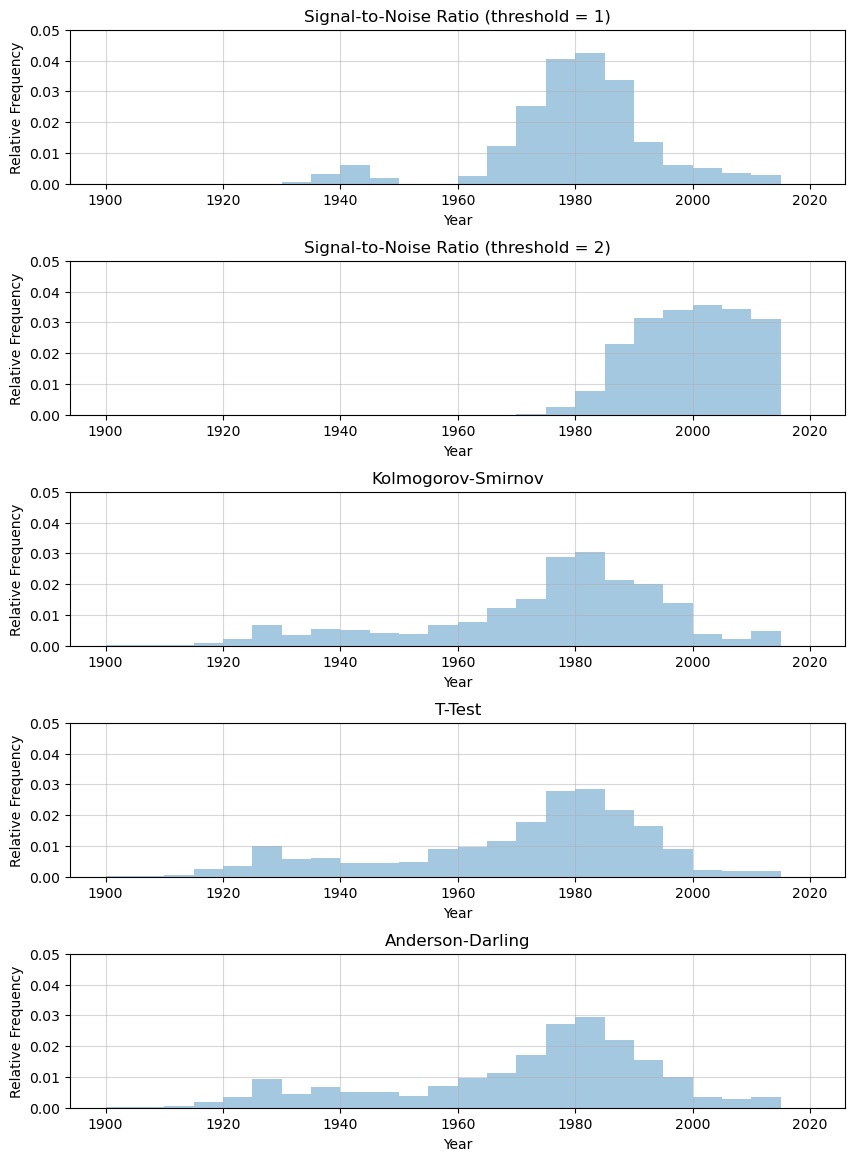

In [188]:
fig = plt.figure(figsize=(10, 14))

gs = gridspec.GridSpec(len(tests_used)+1, 1, hspace=0.5)
axes = [fig.add_subplot(gs[i]) for i in range(len(tests_used)+1)]
bins = np.arange(1900, 2025, 5)
for ax, test in zip(axes[1:], tests_used):
    ax.grid(alpha=0.5, zorder=0)  # Set z-order for the grid lines
    ax.hist(toe_ds[test].values.flatten(), bins=bins, alpha=0.4, density=True)
    title = toe_ds[test].long_name 
    if test == 'signal_to_noise': title = f'{title} (threshold = 2)'
    ax.set_title(title)
    ax.set_xlabel('Year')
    ax.set_ylabel('Relative Frequency')
    ax.set_ylim([0, 0.05])
    
ax = axes[0]
ax.grid(alpha=0.5, zorder=0)
ax.hist(toe_sn_multi_thresh_ds.sel(threshold=1).values.flatten(), bins=bins, alpha=0.4, density=True);
title = toe_ds['signal_to_noise'].long_name
title = f'{title} (threshold = 1)'
ax.set_title(title)
ax.set_xlabel('Year')
ax.set_ylabel('Relative Frequency')
ax.set_ylim([0, 0.05])

## Maps

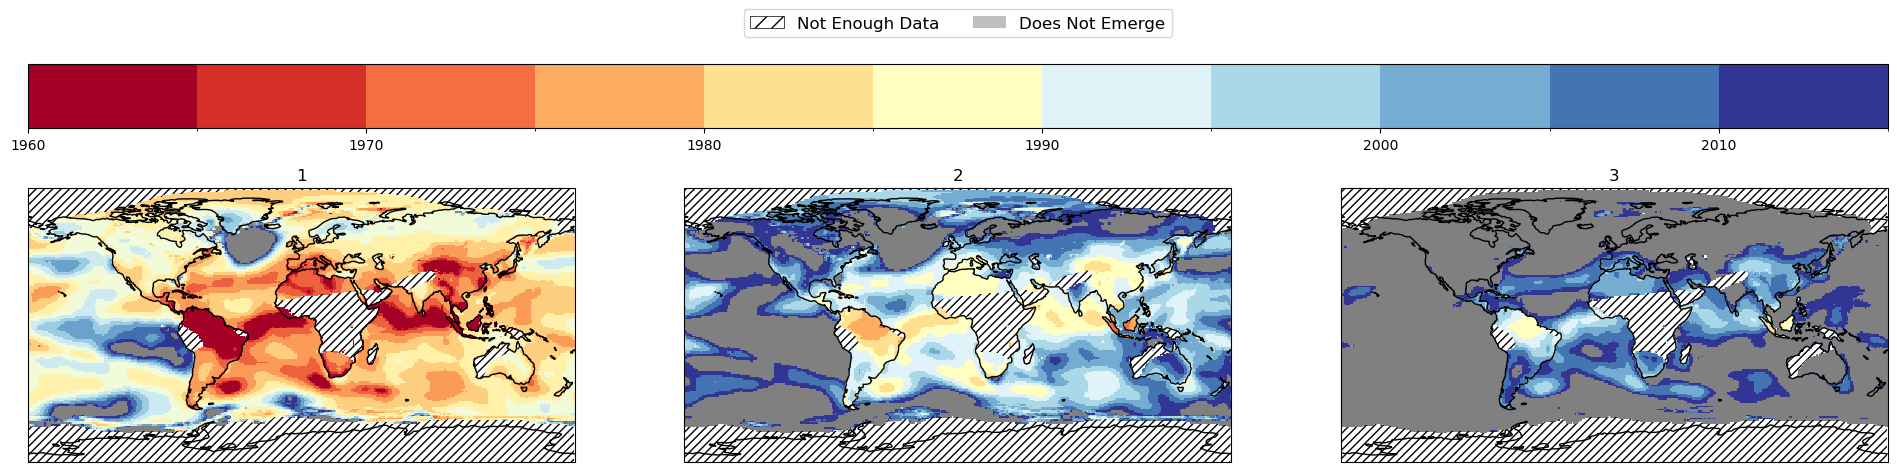

In [109]:
fig = plt.figure(figsize=(16 * 3/2, 10*(1.2/2.2)))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1], height_ratios=[.2, 1])
axes = [fig.add_subplot(gs[1, i], projection=projection) for i in range(3)]

not_stable_kwargs2 = dict(cmap= cmap_binary, add_colorbar=False)
toe_plot_kwargs = dict(cmap='RdYlBu',add_colorbar=False, levels=np.arange(1960, 2020, 5))# vmin=1890, vmax=2020) #viridis_r

for ax, threshold in zip(axes, toe_sn_multi_thresh_ds.threshold.values):
    sn_does_not_emerge_multi_thresh_ds.sel(threshold=threshold).plot(ax=ax, **not_stable_kwargs2)
    toe_plot = toe_sn_multi_thresh_ds.sel(threshold=threshold).plot(ax=ax, **toe_plot_kwargs)
    ax.set_title(threshold)
    ax.coastlines()
    hatch(ax, data_unavailability_mask, **not_stable_kwargs)
    
cbar_axes1 = plt.subplot(gs[0, :])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='horizontal')

# Add a legend for both the hatching and "Does Not Emerge"
legend_elements = [
    plt.Rectangle([0, 0], 1, 1, fc='white', hatch='//', edgecolor='black', lw=0.5),
    plt.Rectangle([0, 0], 1, 1, fc='grey', alpha=0.5)  # Gray for "Does Not Emerge"
]
legend_labels = ['Not Enough Data', 'Does Not Emerge']
legend = cbar_axes1.legend(legend_elements, legend_labels, loc='upper center', bbox_to_anchor=(0.5, 2), fontsize='large', ncol=2)

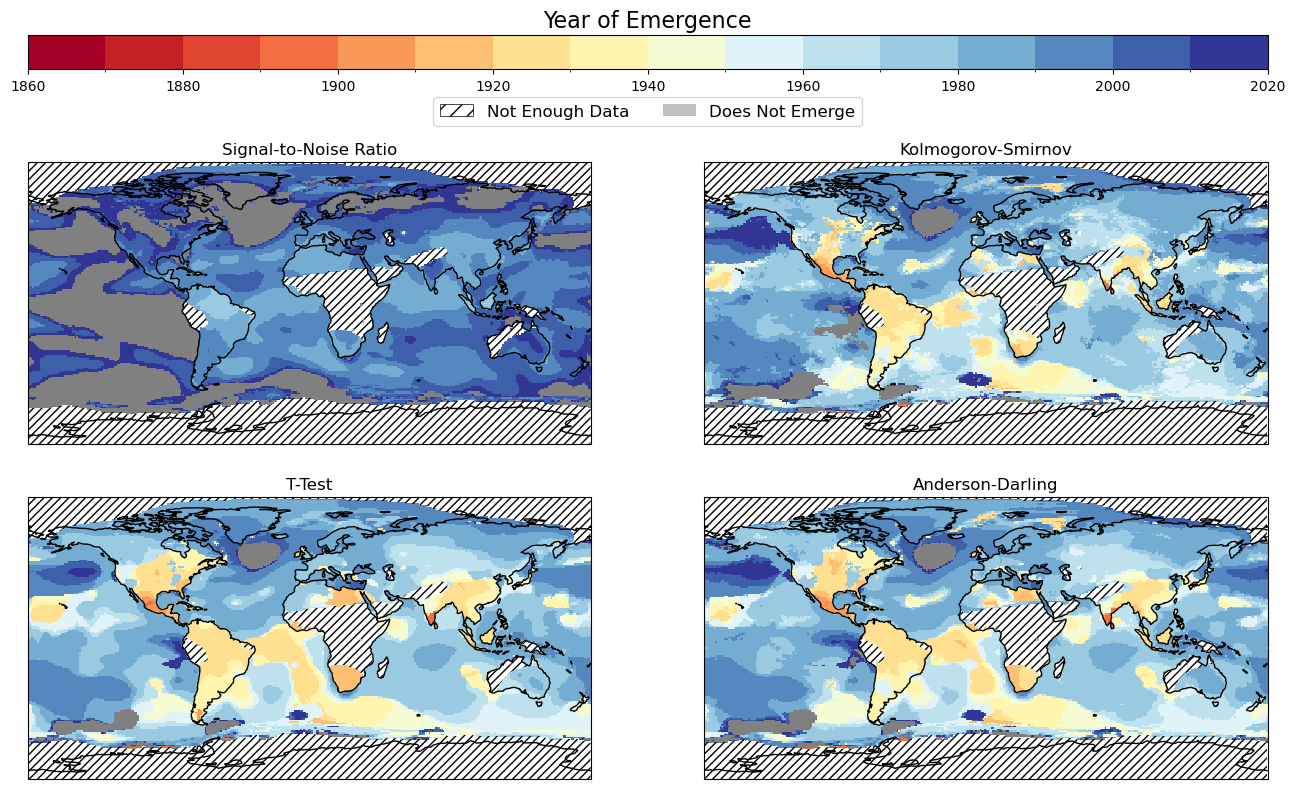

In [110]:
fig = plt.figure(figsize=(16, 10))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(4, 2, width_ratios=[1, 1], height_ratios=[.1, .2, 1, 1], hspace=0.0)
axes = [fig.add_subplot(gs[i], projection=projection) for i in range(4, 8)]

not_stable_kwargs2 = dict(cmap=cmap_binary, add_colorbar=False)
toe_plot_kwargs = dict(cmap='RdYlBu',add_colorbar=False, levels=np.arange(1860, 2030, 10))# vmin=1890, vmax=2020) #viridis_r

for ax, test in zip(axes, tests_used):
    does_not_emerge_ds[test].plot(ax=ax, **not_stable_kwargs2)
    toe_plot = toe_ds[test].plot(ax=ax, **toe_plot_kwargs)
    ax.set_title(toe_ds[test].long_name)
    ax.coastlines()
    hatch(ax, data_unavailability_mask, **not_stable_kwargs)
    
cbar_axes1 = plt.subplot(gs[0, :])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='horizontal')
cbar1.ax.set_title('Year of Emergence', fontsize=16)

# Add a legend for both the hatching and "Does Not Emerge"
legend_elements = [
    plt.Rectangle([0, 0], 1, 1, fc='white', hatch='//', edgecolor='black', lw=0.5),
    plt.Rectangle([0, 0], 1, 1, fc='grey', alpha=0.5)  # Gray for "Does Not Emerge"
]
legend_labels = ['Not Enough Data', 'Does Not Emerge']
legend = cbar_axes1.legend(legend_elements, legend_labels, loc='upper center',bbox_to_anchor=(0.5, -0.6), fontsize=12, ncol=2)


In [147]:
tests_used

['signal_to_noise', 'ks', 'ttest', 'anderson']

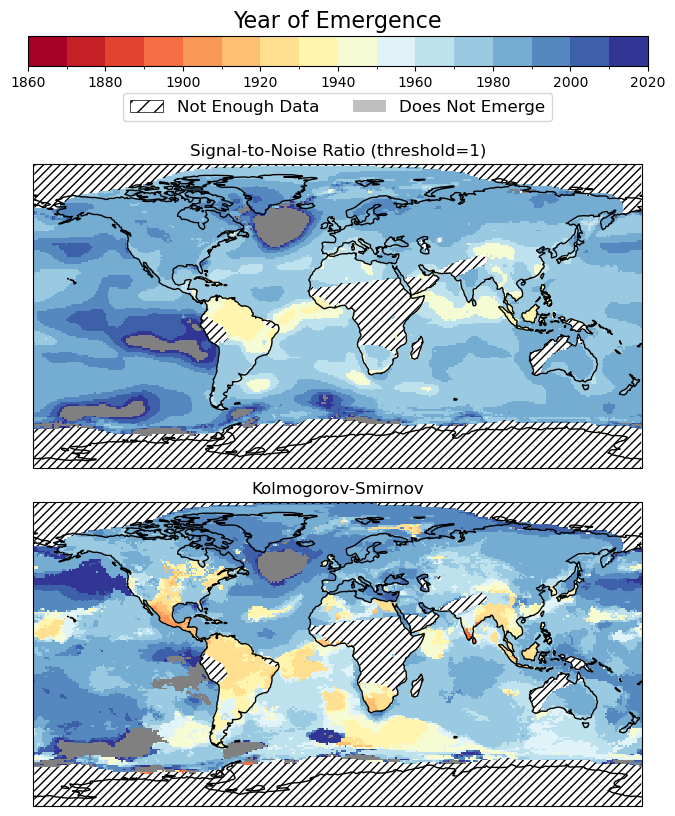

In [164]:
fig = plt.figure(figsize=(8, 10))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(4, 1, height_ratios=[.1, .1, 1, 1], hspace=0.2)
axes = [fig.add_subplot(gs[i+2], projection=projection) for i in range(2)]

not_stable_kwargs2 = dict(cmap=cmap_binary, add_colorbar=False)
toe_plot_kwargs = dict(cmap='RdYlBu',add_colorbar=False, levels=np.arange(1860, 2030, 10))# vmin=1890, vmax=2020) #viridis_r

for ax, test in zip(axes, ['signal_to_noise', 'ks']):
    if test == 'signal_to_noise':
        toe_sn_multi_thresh_ds.sel(threshold=1).plot(ax=ax, **toe_plot_kwargs)
        sn_does_not_emerge_multi_thresh_ds.sel(threshold=1).plot(ax=ax, **not_stable_kwargs2)
        title = toe_ds[test].long_name + ' (threshold=1)'
    else:
        does_not_emerge_ds[test].plot(ax=ax, **not_stable_kwargs2)
        toe_plot = toe_ds[test].plot(ax=ax, **toe_plot_kwargs)
        title = toe_ds[test].long_name
    ax.set_title(title)
    ax.coastlines()
    hatch(ax, data_unavailability_mask, **not_stable_kwargs)
    
cbar_axes1 = plt.subplot(gs[0, :])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='horizontal')
cbar1.ax.set_title('Year of Emergence', fontsize=16)

# Add a legend for both the hatching and "Does Not Emerge"
legend_elements = [
    plt.Rectangle([0, 0], 1, 1, fc='white', hatch='//', edgecolor='black', lw=0.5),
    plt.Rectangle([0, 0], 1, 1, fc='grey', alpha=0.5)  # Gray for "Does Not Emerge"
]
legend_labels = ['Not Enough Data', 'Does Not Emerge']
legend = cbar_axes1.legend(legend_elements, legend_labels, loc='upper center',bbox_to_anchor=(0.5, -0.6), fontsize=12, ncol=2)


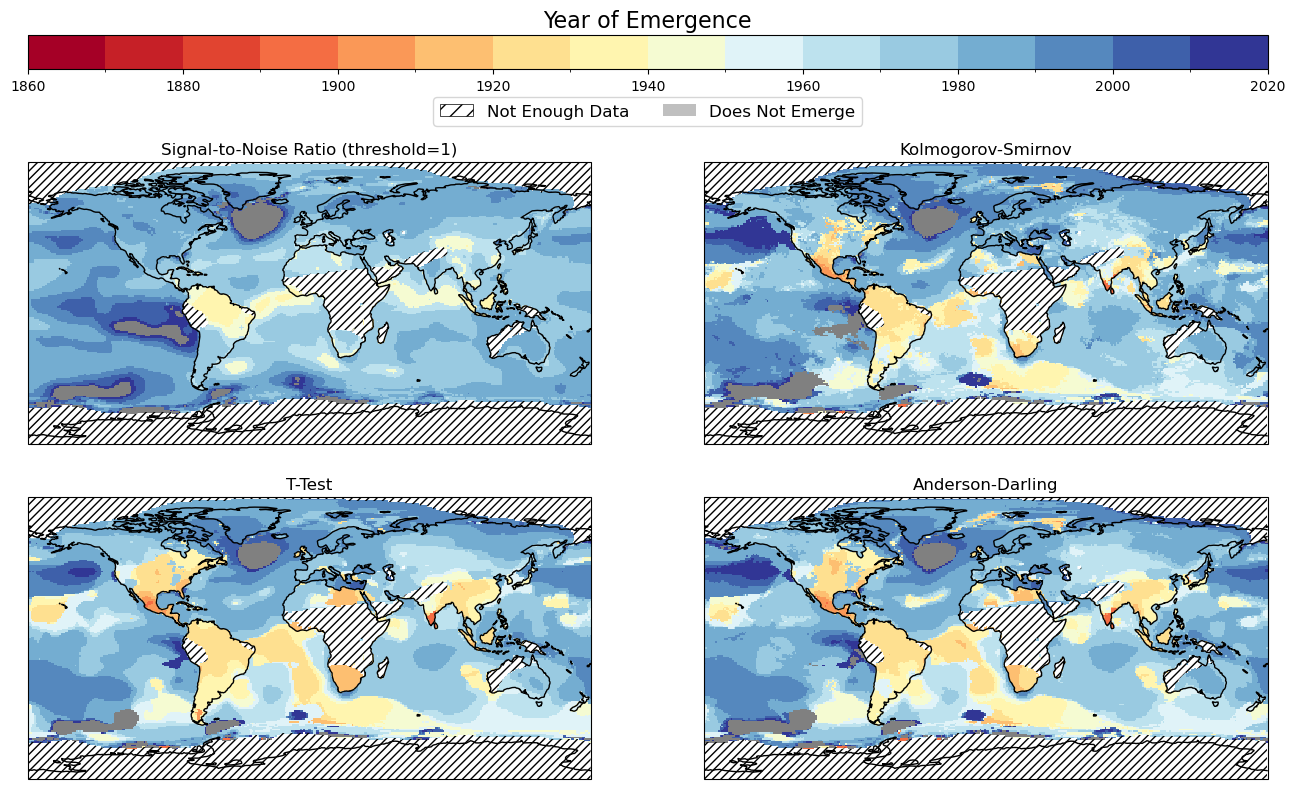

In [111]:
fig = plt.figure(figsize=(16, 10))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(4, 2, width_ratios=[1, 1], height_ratios=[.1, .2, 1, 1], hspace=0.0)
axes = [fig.add_subplot(gs[i], projection=projection) for i in range(4, 8)]

not_stable_kwargs2 = dict(cmap=cmap_binary, add_colorbar=False)
toe_plot_kwargs = dict(cmap='RdYlBu',add_colorbar=False, levels=np.arange(1860, 2030, 10))# vmin=1890, vmax=2020) #viridis_r

for ax, test in zip(axes, tests_used):
    if test == 'signal_to_noise':
        toe_sn_multi_thresh_ds.sel(threshold=1).plot(ax=ax, **toe_plot_kwargs)
        sn_does_not_emerge_multi_thresh_ds.sel(threshold=1).plot(ax=ax, **not_stable_kwargs2)
        title = toe_ds[test].long_name + ' (threshold=1)'
    else:
        does_not_emerge_ds[test].plot(ax=ax, **not_stable_kwargs2)
        toe_plot = toe_ds[test].plot(ax=ax, **toe_plot_kwargs)
        title = toe_ds[test].long_name
    ax.set_title(title)
    ax.coastlines()
    hatch(ax, data_unavailability_mask, **not_stable_kwargs)
    
cbar_axes1 = plt.subplot(gs[0, :])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='horizontal')
cbar1.ax.set_title('Year of Emergence', fontsize=16)

# Add a legend for both the hatching and "Does Not Emerge"
legend_elements = [
    plt.Rectangle([0, 0], 1, 1, fc='white', hatch='//', edgecolor='black', lw=0.5),
    plt.Rectangle([0, 0], 1, 1, fc='grey', alpha=0.5)  # Gray for "Does Not Emerge"
]
legend_labels = ['Not Enough Data', 'Does Not Emerge']
legend = cbar_axes1.legend(legend_elements, legend_labels, loc='upper center',bbox_to_anchor=(0.5, -0.6), fontsize=12, ncol=2)


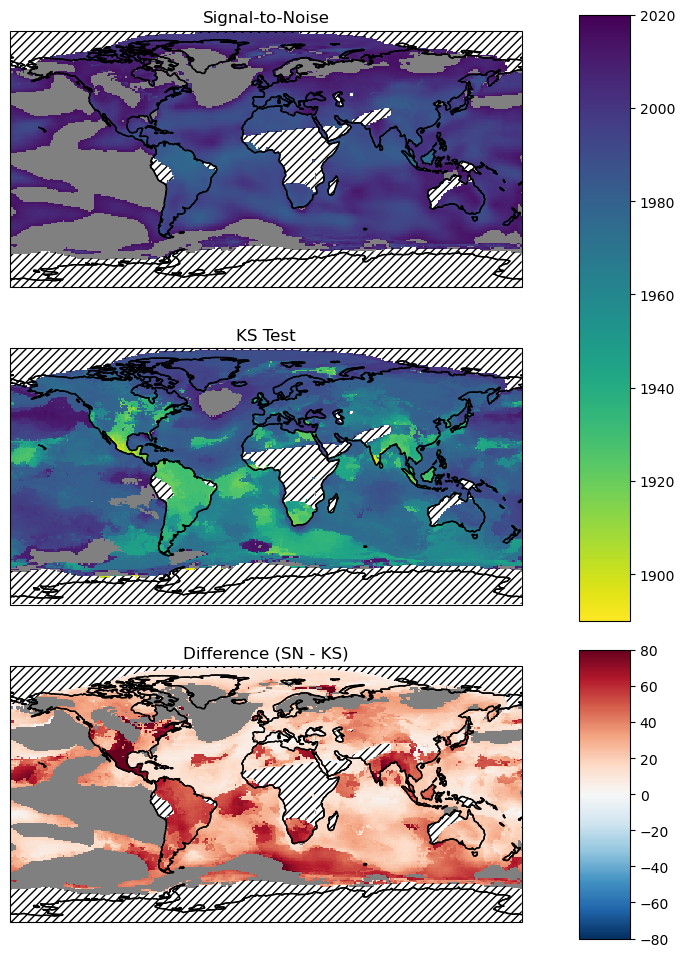

In [112]:
fig = plt.figure(figsize=(8, 12))
projection=ccrs.PlateCarree()

gs = gridspec.GridSpec(3, 2, width_ratios=[1, 0.1], hspace=0.1)
axes = [fig.add_subplot(gs[i, 0], projection=projection) for i in range(3)]

toe_plot_kwargs = dict(cmap='viridis_r',add_colorbar=False, vmin=1890, vmax=2020)

does_not_emerge_ds['signal_to_noise'].plot(ax=axes[0], **not_stable_kwargs2)
does_not_emerge_ds['ks'].plot(ax=axes[1], **not_stable_kwargs2)
(does_not_emerge_ds['ks'] | does_not_emerge_ds['signal_to_noise']).plot(ax=axes[2], **not_stable_kwargs2)

toe_ds['signal_to_noise'].plot(ax=axes[0], **toe_plot_kwargs)
toe_plot = toe_ds['ks'].plot(ax=axes[1], **toe_plot_kwargs)

cbar_axes1 = plt.subplot(gs[:2, 1])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='vertical')

diff_plot = difference_sn_ks_ds.plot(ax=axes[2], add_colorbar=False, vmin=-80, vmax=80, cmap='RdBu_r')

cbar_axes2 = plt.subplot(gs[2, 1])
cbar2 = plt.colorbar(diff_plot, cax=cbar_axes2, orientation='vertical')

for ax in axes: ax.coastlines()

axes[0].set_title('Signal-to-Noise')
axes[1].set_title('KS Test')
axes[2].set_title('Difference (SN - KS)')

for ax in axes:
    ax.coastlines()
    hatch(ax, data_unavailability_mask, **not_stable_kwargs)


## Point Selection Plots

In [113]:
best_ds

<xarray.DataArray 'temperature' (time: 175, lat: 180, lon: 360)>
array([[[nan, ..., nan],
        ...,
        [nan, ..., nan]],

       ...,

       [[nan, ..., nan],
        ...,
        [nan, ..., nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * time     (time) object 1850-12-31 00:00:00 ... 2024-12-31 00:00:00

In [114]:
### Asia Targeting

asia_lat_lon_max =\
    utils.find_nth_extreme_location(
        difference_sn_ks_ds.sel(toe_const.LocationBoxes.ASIA.value), 'max',
    output_dtype='dict')

asia_lat_lon_min =\
    utils.find_nth_extreme_location(
        difference_sn_ks_ds.sel(toe_const.LocationBoxes.ASIA.value), 'min',
    output_dtype='dict')

asia_lat_lon_max, asia_lat_lon_min

({'lat': 17.5, 'lon': 81.5}, {'lat': 32.5, 'lon': 107.5})

In [115]:
### North America Targeting

na_lat_lon_max =\
    utils.find_nth_extreme_location(
        difference_sn_ks_ds.sel(toe_const.LocationBoxes.NORTH_AMERICA_LAND_TARGET.value), 'max',
    output_dtype='dict')

na_lat_lon_min ={'lat': 22.5, 'lon': -94.5}

na_lat_lon_max, na_lat_lon_min

({'lat': 22.5, 'lon': -103.5}, {'lat': 22.5, 'lon': -94.5})

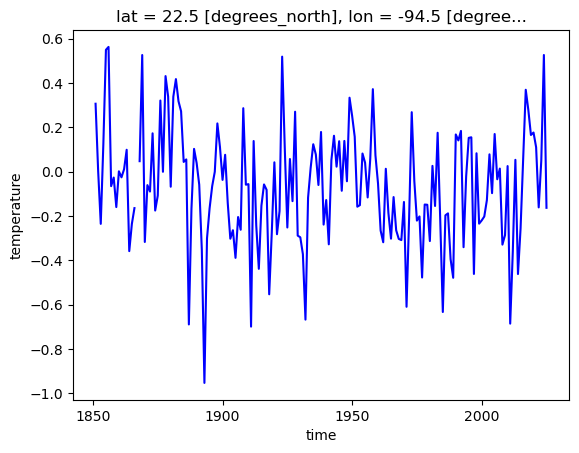

In [346]:
ds_best_noise_series.sel(**na_lat_lon_min).plot(color='blue', label='Noise series')


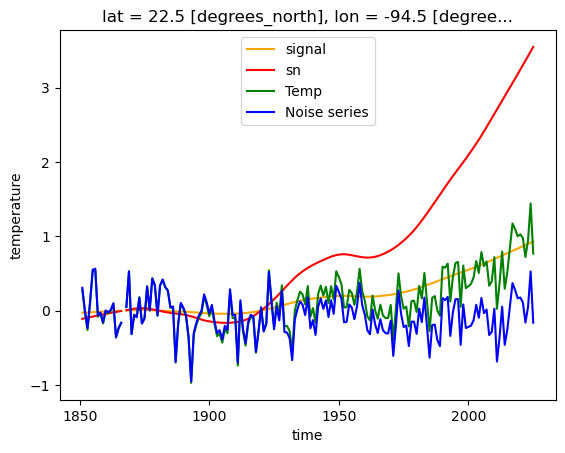

In [283]:
fig, ax1 = plt.subplots(1, 1)
ax2 = ax1#.twinx()
ds_best_signal.sel(**na_lat_lon_min).plot(ax=ax1, label='signal', color='orange')
ds_best_sn.sel(**na_lat_lon_min).plot(ax=ax1, label='sn', color='red')

best_ds.sel(**na_lat_lon_min).plot(ax=ax2, label='Temp', color='green')
ds_best_noise_series.sel(**na_lat_lon_min).plot(ax=ax2, color='blue', label='Noise series')

ax1.legend()
ax2.legend(loc='upper center')

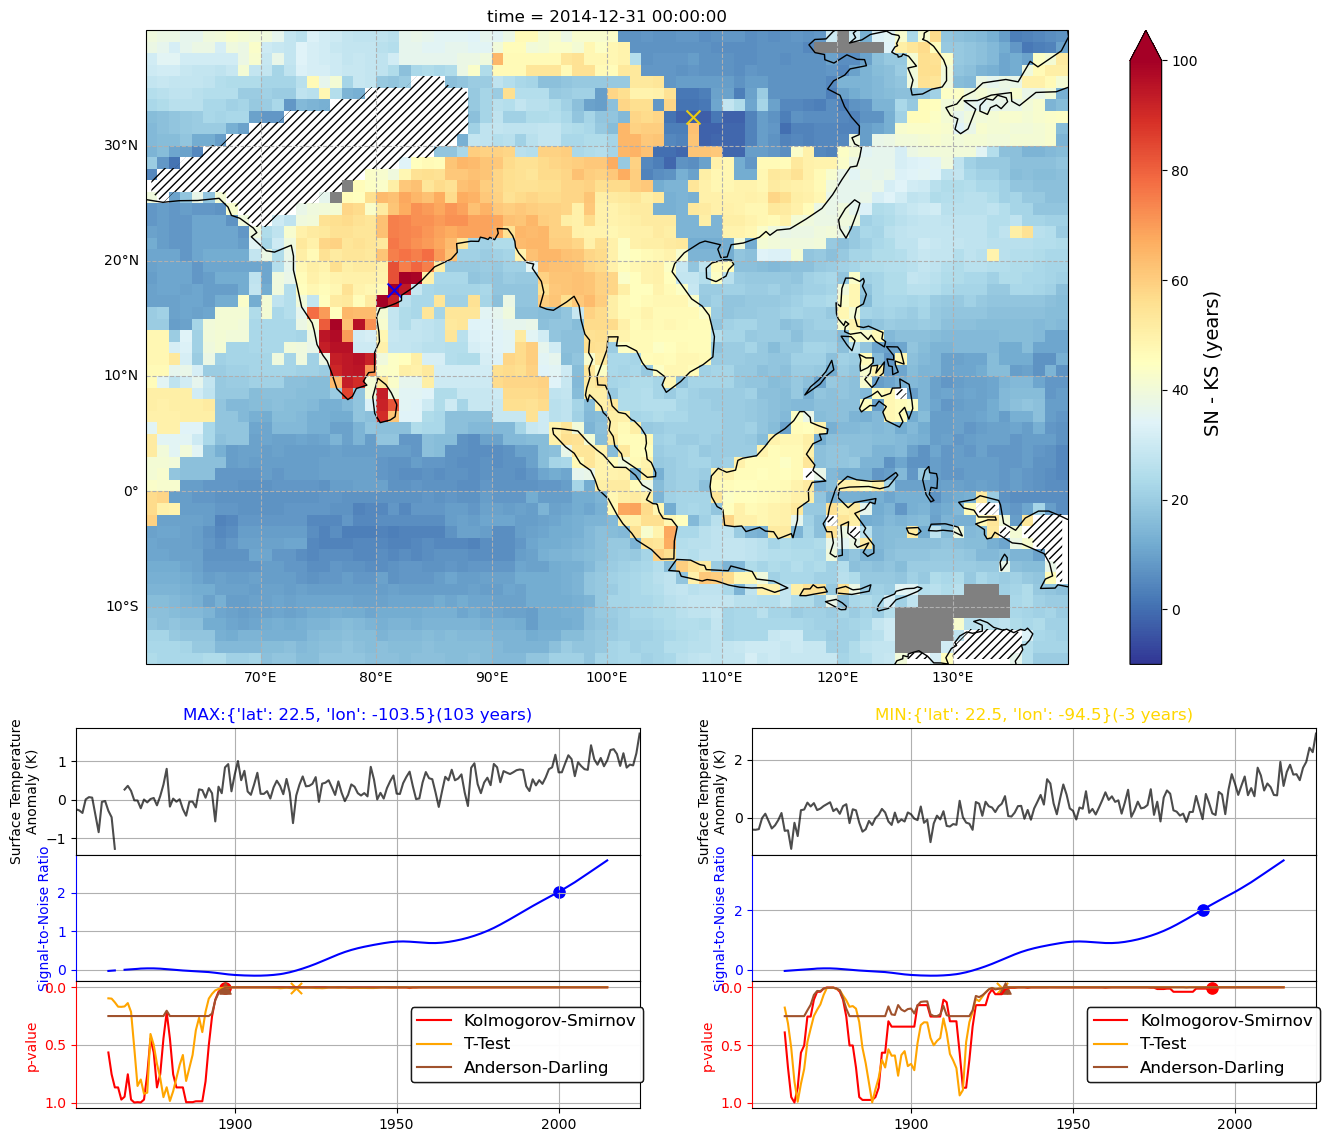

In [117]:
fig = plt.figure(figsize=(16, 14))
gs = gridspec.GridSpec(5, 2, hspace=0, height_ratios = [1, 0.1]+ [0.2]*3) 
ax_top = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree())
axes_left = [fig.add_subplot(gs[i+2, 0]) for i in range(3)]
axes_right = [fig.add_subplot(gs[i+2, 1]) for i in range(3)]

plot = difference_sn_ks_ds.sel(toe_const.LocationBoxes.ASIA.value).plot(ax=ax_top, cmap='RdYlBu_r', vmin=-10, vmax=100, cbar_kwargs={'label':'Difference (years)'})
# Adjust colorbar label size
cbar = plot.colorbar
cbar.set_label('SN - KS (years)', fontsize=14) 
ax_top.scatter(x=asia_lat_lon_max['lon'], y=asia_lat_lon_max['lat'], marker='x', alpha=.9, s=100, color='blue')
ax_top.scatter(x=asia_lat_lon_min['lon'], y=asia_lat_lon_min['lat'], marker='x', alpha=.9, s=100, color='gold')
hatch(ax_top, data_unavailability_mask.sel(toe_const.LocationBoxes.ASIA.value), **not_stable_kwargs)

(
    (does_not_emerge_ds['ks'] | does_not_emerge_ds['signal_to_noise'])
     .sel(toe_const.LocationBoxes.ASIA.value)
    .plot(ax=ax_top, **not_stable_kwargs2)
)

plotting_utils.format_lat_lon(ax_top)
ax_top.coastlines()


axes_left[0].set_title('MAX:'+str(na_lat_lon_max) + f'({str(difference_sn_ks_ds.sel(**asia_lat_lon_max).astype(int).values)} years)', color='blue')
time_of_emergence_plots.plot_multiseries_with_pvalues(toe_metrics_ds.sel(**asia_lat_lon_max, method='nearest'),
                              toe_ds.sel(**asia_lat_lon_max, method='nearest'),
                              best_ds.sel(**asia_lat_lon_max, method='nearest'), 
                             fig=fig, gs=gs, axes=axes_left)


axes_right[0].set_title('MIN:'+str(na_lat_lon_min) + f'({str(difference_sn_ks_ds.sel(**asia_lat_lon_min).astype(int).values)} years)', color='gold')
time_of_emergence_plots.plot_multiseries_with_pvalues(toe_metrics_ds.sel(**asia_lat_lon_min, method='nearest'),
                              toe_ds.sel(**asia_lat_lon_min, method='nearest'),
                              best_ds.sel(**asia_lat_lon_min, method='nearest'), 
                             fig=fig, gs=gs, axes=axes_right)

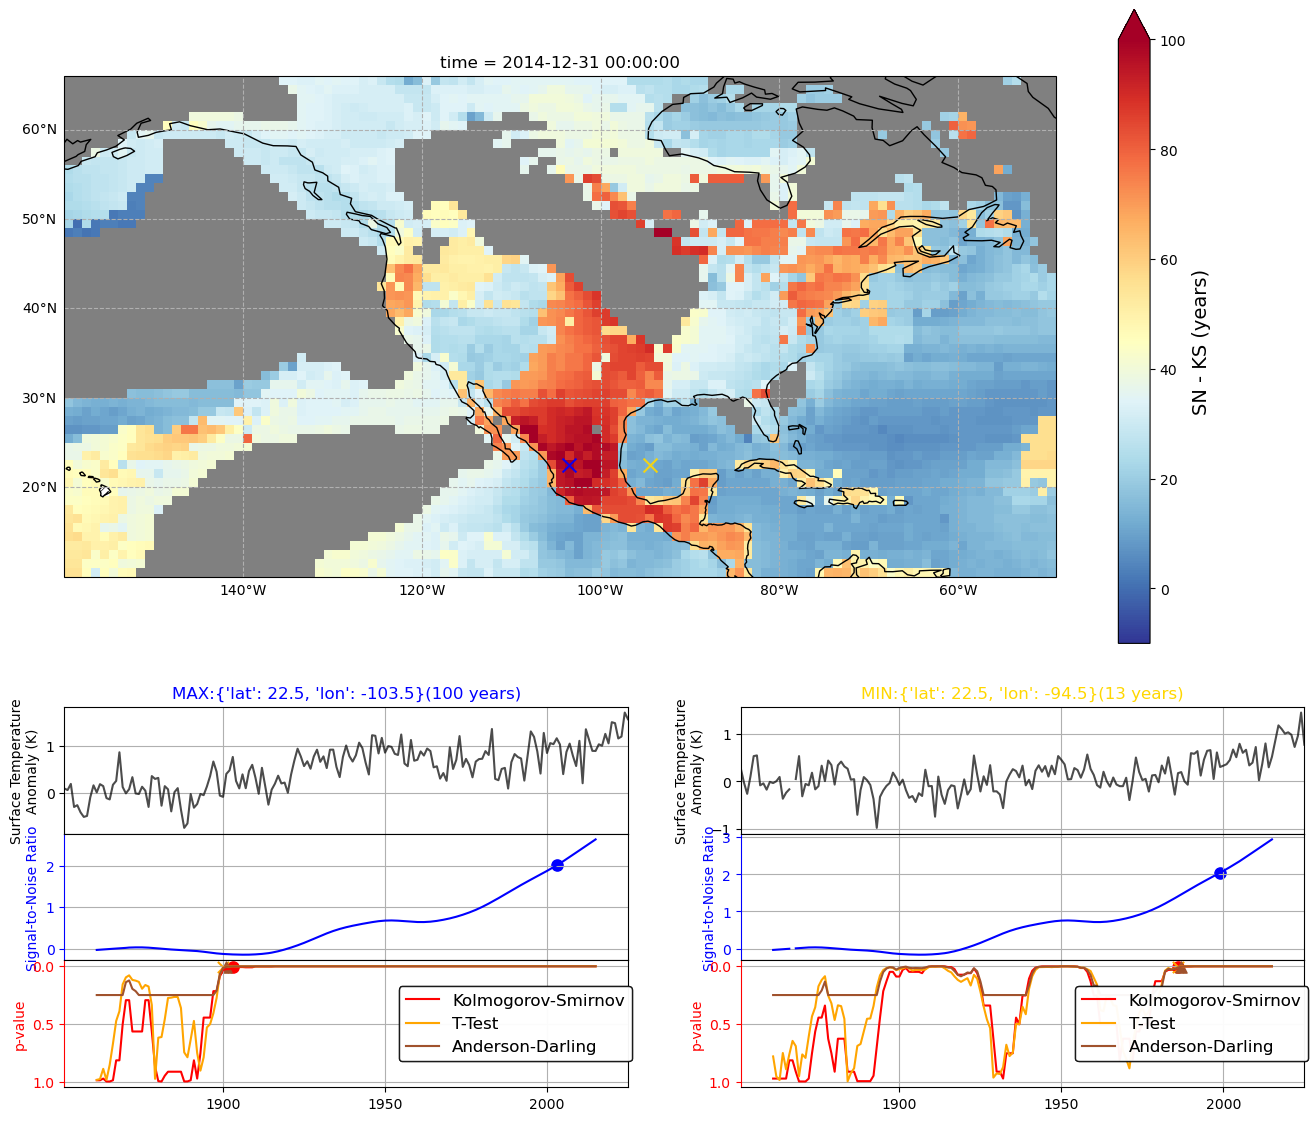

In [118]:
fig = plt.figure(figsize=(16, 14))
gs = gridspec.GridSpec(5, 2, hspace=0, height_ratios = [1, 0.1]+ [0.2]*3) 
ax_top = fig.add_subplot(gs[0, :], projection=ccrs.PlateCarree())
axes_left = [fig.add_subplot(gs[i+2, 0]) for i in range(3)]
axes_right = [fig.add_subplot(gs[i+2, 1]) for i in range(3)]

plot = difference_sn_ks_ds.sel(toe_const.LocationBoxes.NORTH_AMERICA.value).plot(ax=ax_top, cmap='RdYlBu_r', vmin=-10, vmax=100, cbar_kwargs={'label':'Difference (years)'})
# Adjust colorbar label size
cbar = plot.colorbar
cbar.set_label('SN - KS (years)', fontsize=14) 
ax_top.scatter(x=na_lat_lon_max['lon'], y=na_lat_lon_max['lat'], marker='x', alpha=.9, s=100, color='blue')
ax_top.scatter(x=na_lat_lon_min['lon'], y=na_lat_lon_min['lat'], marker='x', alpha=.9, s=100, color='gold')

plotting_utils.format_lat_lon(ax_top)
ax_top.coastlines()
hatch(ax_top, data_unavailability_mask.sel(toe_const.LocationBoxes.NORTH_AMERICA.value), **not_stable_kwargs)

(
    (does_not_emerge_ds['ks'] | does_not_emerge_ds['signal_to_noise'])
     .sel(toe_const.LocationBoxes.NORTH_AMERICA.value)
    .plot(ax=ax_top, **not_stable_kwargs2)
)


axes_left[0].set_title('MAX:'+str(na_lat_lon_max) + f'({str(difference_sn_ks_ds.sel(**na_lat_lon_max).astype(int).values)} years)', color='blue')
time_of_emergence_plots.plot_multiseries_with_pvalues(toe_metrics_ds.sel(**na_lat_lon_max, method='nearest'),
                              toe_ds.sel(**na_lat_lon_max, method='nearest'),
                              best_ds.sel(**na_lat_lon_max, method='nearest'), 
                             fig=fig, gs=gs, axes=axes_left)


axes_right[0].set_title('MIN:'+str(na_lat_lon_min) + f'({str(difference_sn_ks_ds.sel(**na_lat_lon_min).astype(int).values)} years)', color='gold')
time_of_emergence_plots.plot_multiseries_with_pvalues(toe_metrics_ds.sel(**na_lat_lon_min, method='nearest'),
                              toe_ds.sel(**na_lat_lon_min, method='nearest'),
                              best_ds.sel(**na_lat_lon_min, method='nearest'), 
                             fig=fig, gs=gs, axes=axes_right)

## Stability Time Series

In [119]:
REGION_STYLE_DICT = {
    'land': {'color': 'brown', 'linestyle': '--'}, 
    'ocean': {'color': 'blue', 'linestyle': '--'},
    'nh': {'color': 'm', 'linestyle': (0, (1, 1))}, 
    'sh': {'color': 'orange', 'linestyle': (0, (1, 1))},
    'tropics': {'color': 'darkgreen', 'linestyle': '--'}, 
    'mid_lat_nh': {'color': 'red', 'linestyle': '-'}, 
    'mid_lat_sh': {'color': 'tomato', 'linestyle': '--'},
    'arctic': {'color': 'lightblue', 'linestyle': '-'}, 
    'antarctic': {'color': 'darkblue'},
    'global': {'color': 'black', 'linestyle': '-', 'linewidth': 5, 'zorder': 100}
}


In [120]:
time_of_emergence_plots.TEST_PLOT_DICT

{'ks': {'color': 'red', 'marker': 'o'},
 'ttest': {'color': 'orange', 'marker': 'x'},
 'anderson': {'color': 'sienna', 'marker': '^'},
 'signal_to_noise': {'color': 'blue', 'marker': 'o'}}

In [121]:
ks_sn_time_series_diff_ds = (emergence_time_series_ds['ks'] - emergence_time_series_ds['signal_to_noise'])

Text(0.5, 0, 'Time')

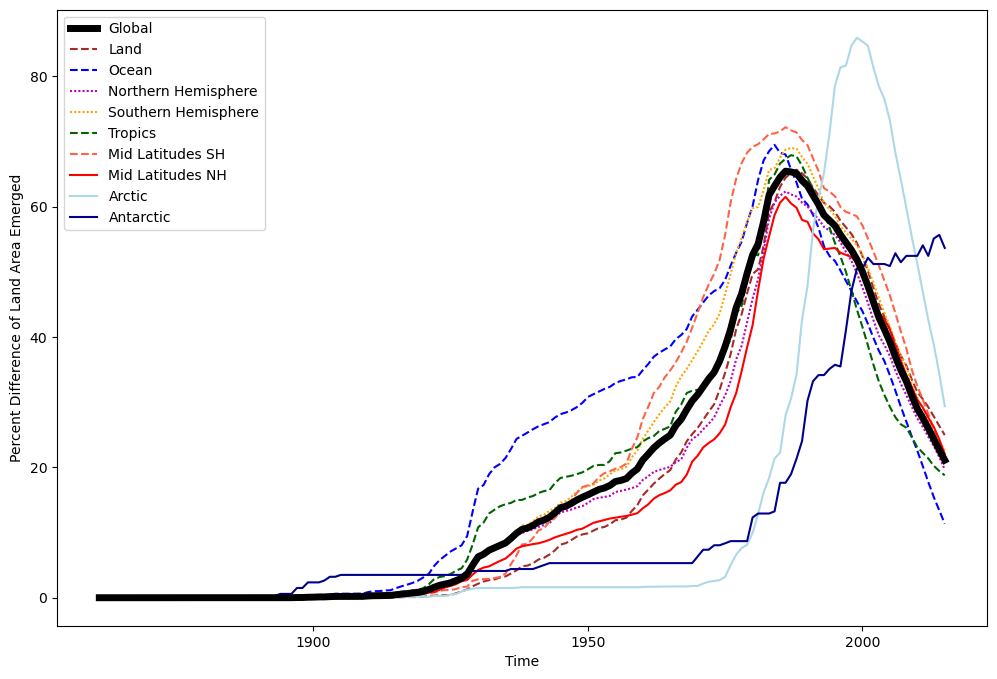

In [122]:
fig, ax = plt.subplots(figsize=(12, 8))

time = ks_sn_time_series_diff_ds.time.values
for region in ks_sn_time_series_diff_ds.region.values:
    ax.plot(time, ks_sn_time_series_diff_ds.sel(region=region).values, **REGION_STYLE_DICT.get(region, ''),
           label=toe_const.NAMING_MAP.get(region, region))

ax.legend()
ax.set_ylabel('Percent Difference of Land Area Emerged')
ax.set_xlabel('Time')

In [123]:
emergence_time_series_ds.attrs[region]

{'available': 309, 'maximimum': 8640}

global


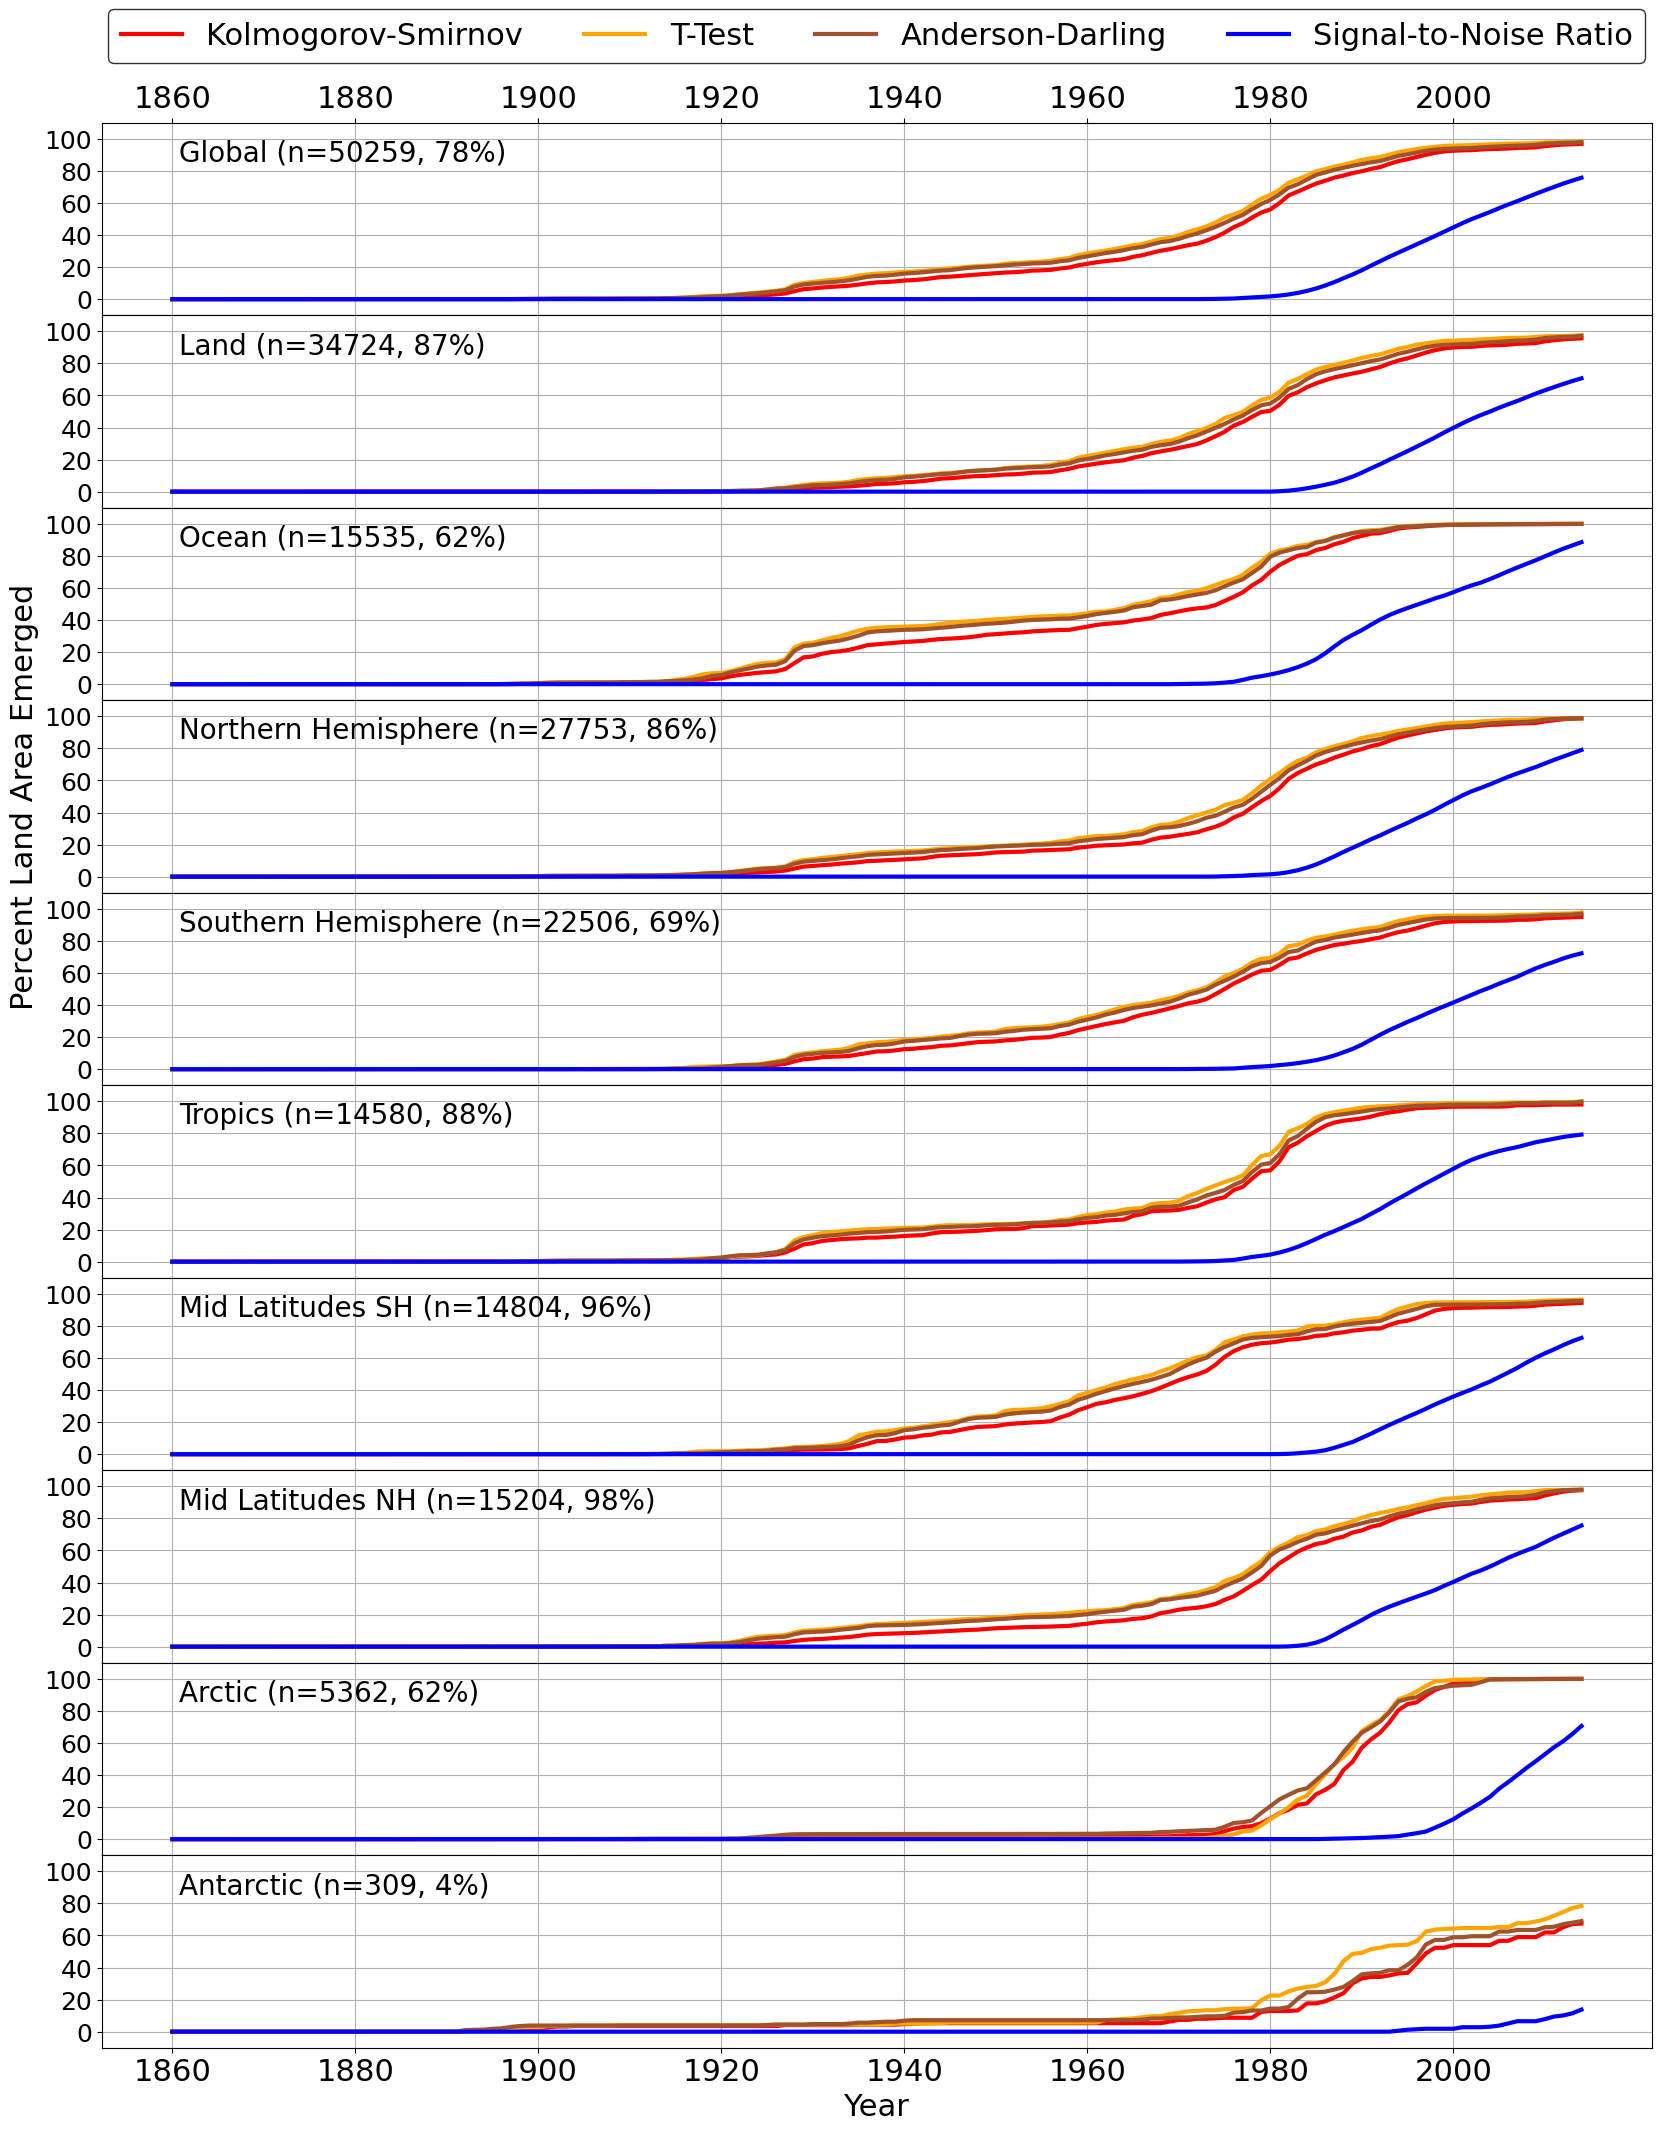

In [124]:
### Plot Creation
nplots = len(emergence_time_series_ds.region.values)
fig = plt.figure(figsize=(20, 25))
gs = gridspec.GridSpec(nplots, 1, wspace=0, hspace=0)
axes = [fig.add_subplot(gs[i]) for i in range(nplots)]
# axes.insert(0, fig.add_subplot(gs[0])) # Insert a large subplot at the strage

time = emergence_time_series_ds.time.values

for num, region in enumerate(emergence_time_series_ds.region.values):
    ax=axes[num]
    kwargs_to_use ={}#left_kwargs if ((num%2) or (num==0)) else {}
    # for region in regions:
    region_emergence_ds = emergence_time_series_ds.sel(region=region)
    for test in list(region_emergence_ds.data_vars):
        color = time_of_emergence_plots.TEST_PLOT_DICT.get(test, {}).get('color', 'red')
        label = toe_const.NAME_CONVERSION_DICT.get(test, '')
        ax.plot(time, region_emergence_ds[test].values, color=color, label=label, linewidth=3)
    ax.grid()
    ax.tick_params(axis='y', labelsize=18)
    ax.tick_params(axis='x', labelsize=22)
    number_of_points = int(emergence_time_series_ds.attrs[region]['available'])
    percent_available = (number_of_points/int(emergence_time_series_ds.attrs[region]['maximimum'])) *100
    ax.annotate(toe_const.NAMING_MAP.get(region, region) + f' (n={number_of_points}, {percent_available:.0f}%)', xy=(0.05, 0.8), size=20, xycoords='axes fraction')

    ax.set_yticks(np.arange(0, 120, 20))#np.take(ax.get_yticks(), np.arange(1, len(ax.get_yticks())-1)))
    ax.set_ylim(-10, 110)

    # Mticker seems to be broken. Not returning the correct year at the correct points

    # Ticks every 20 years
    # Getting just the locations where the year is divisible by 10 with no remainder.
    # Then getting every second one/
    tick_locations = list(filter(lambda t: t.year % 10 == 0, time))[::2]
    ax.set_xticks(tick_locations)
    ax.set_xticklabels(list(map(lambda t:t.year, tick_locations)))

    
    #ax.xaxis.set_major_locator(mdates.YearLocator(base=20))
    #ax.xaxis.set_minor_locator(mdates.YearLocator(base=10))
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    if num in [0]:
        print(region)
        ax.xaxis.tick_top()
    
    # if not num%2 and num >1:
    #     ax.set_yticklabels([])
    #     ax.set_ylabel('')
    # else: 
    if num == 3: ax.set_ylabel('Percent Land Area Emerged', fontsize=22)

    if 2 < num < 8: ax.set_xticklabels([]) # Need or the last number can still be seen
    else: ax.set_xlabel('Year', fontsize=22)

# Create the legend
legend = axes[0].legend(ncol=4, loc='center', bbox_to_anchor=(0.5, 1.45), frameon=True, fontsize=22)
frame = legend.get_frame()
frame.set_color('white')  # Set the legend frame color to white
frame.set_edgecolor('black')  # Set the legend frame edge color to black


In [126]:
emergence_time_series_ds.attrs[region]

{'available': 50259, 'maximimum': 64800}

land
ocean


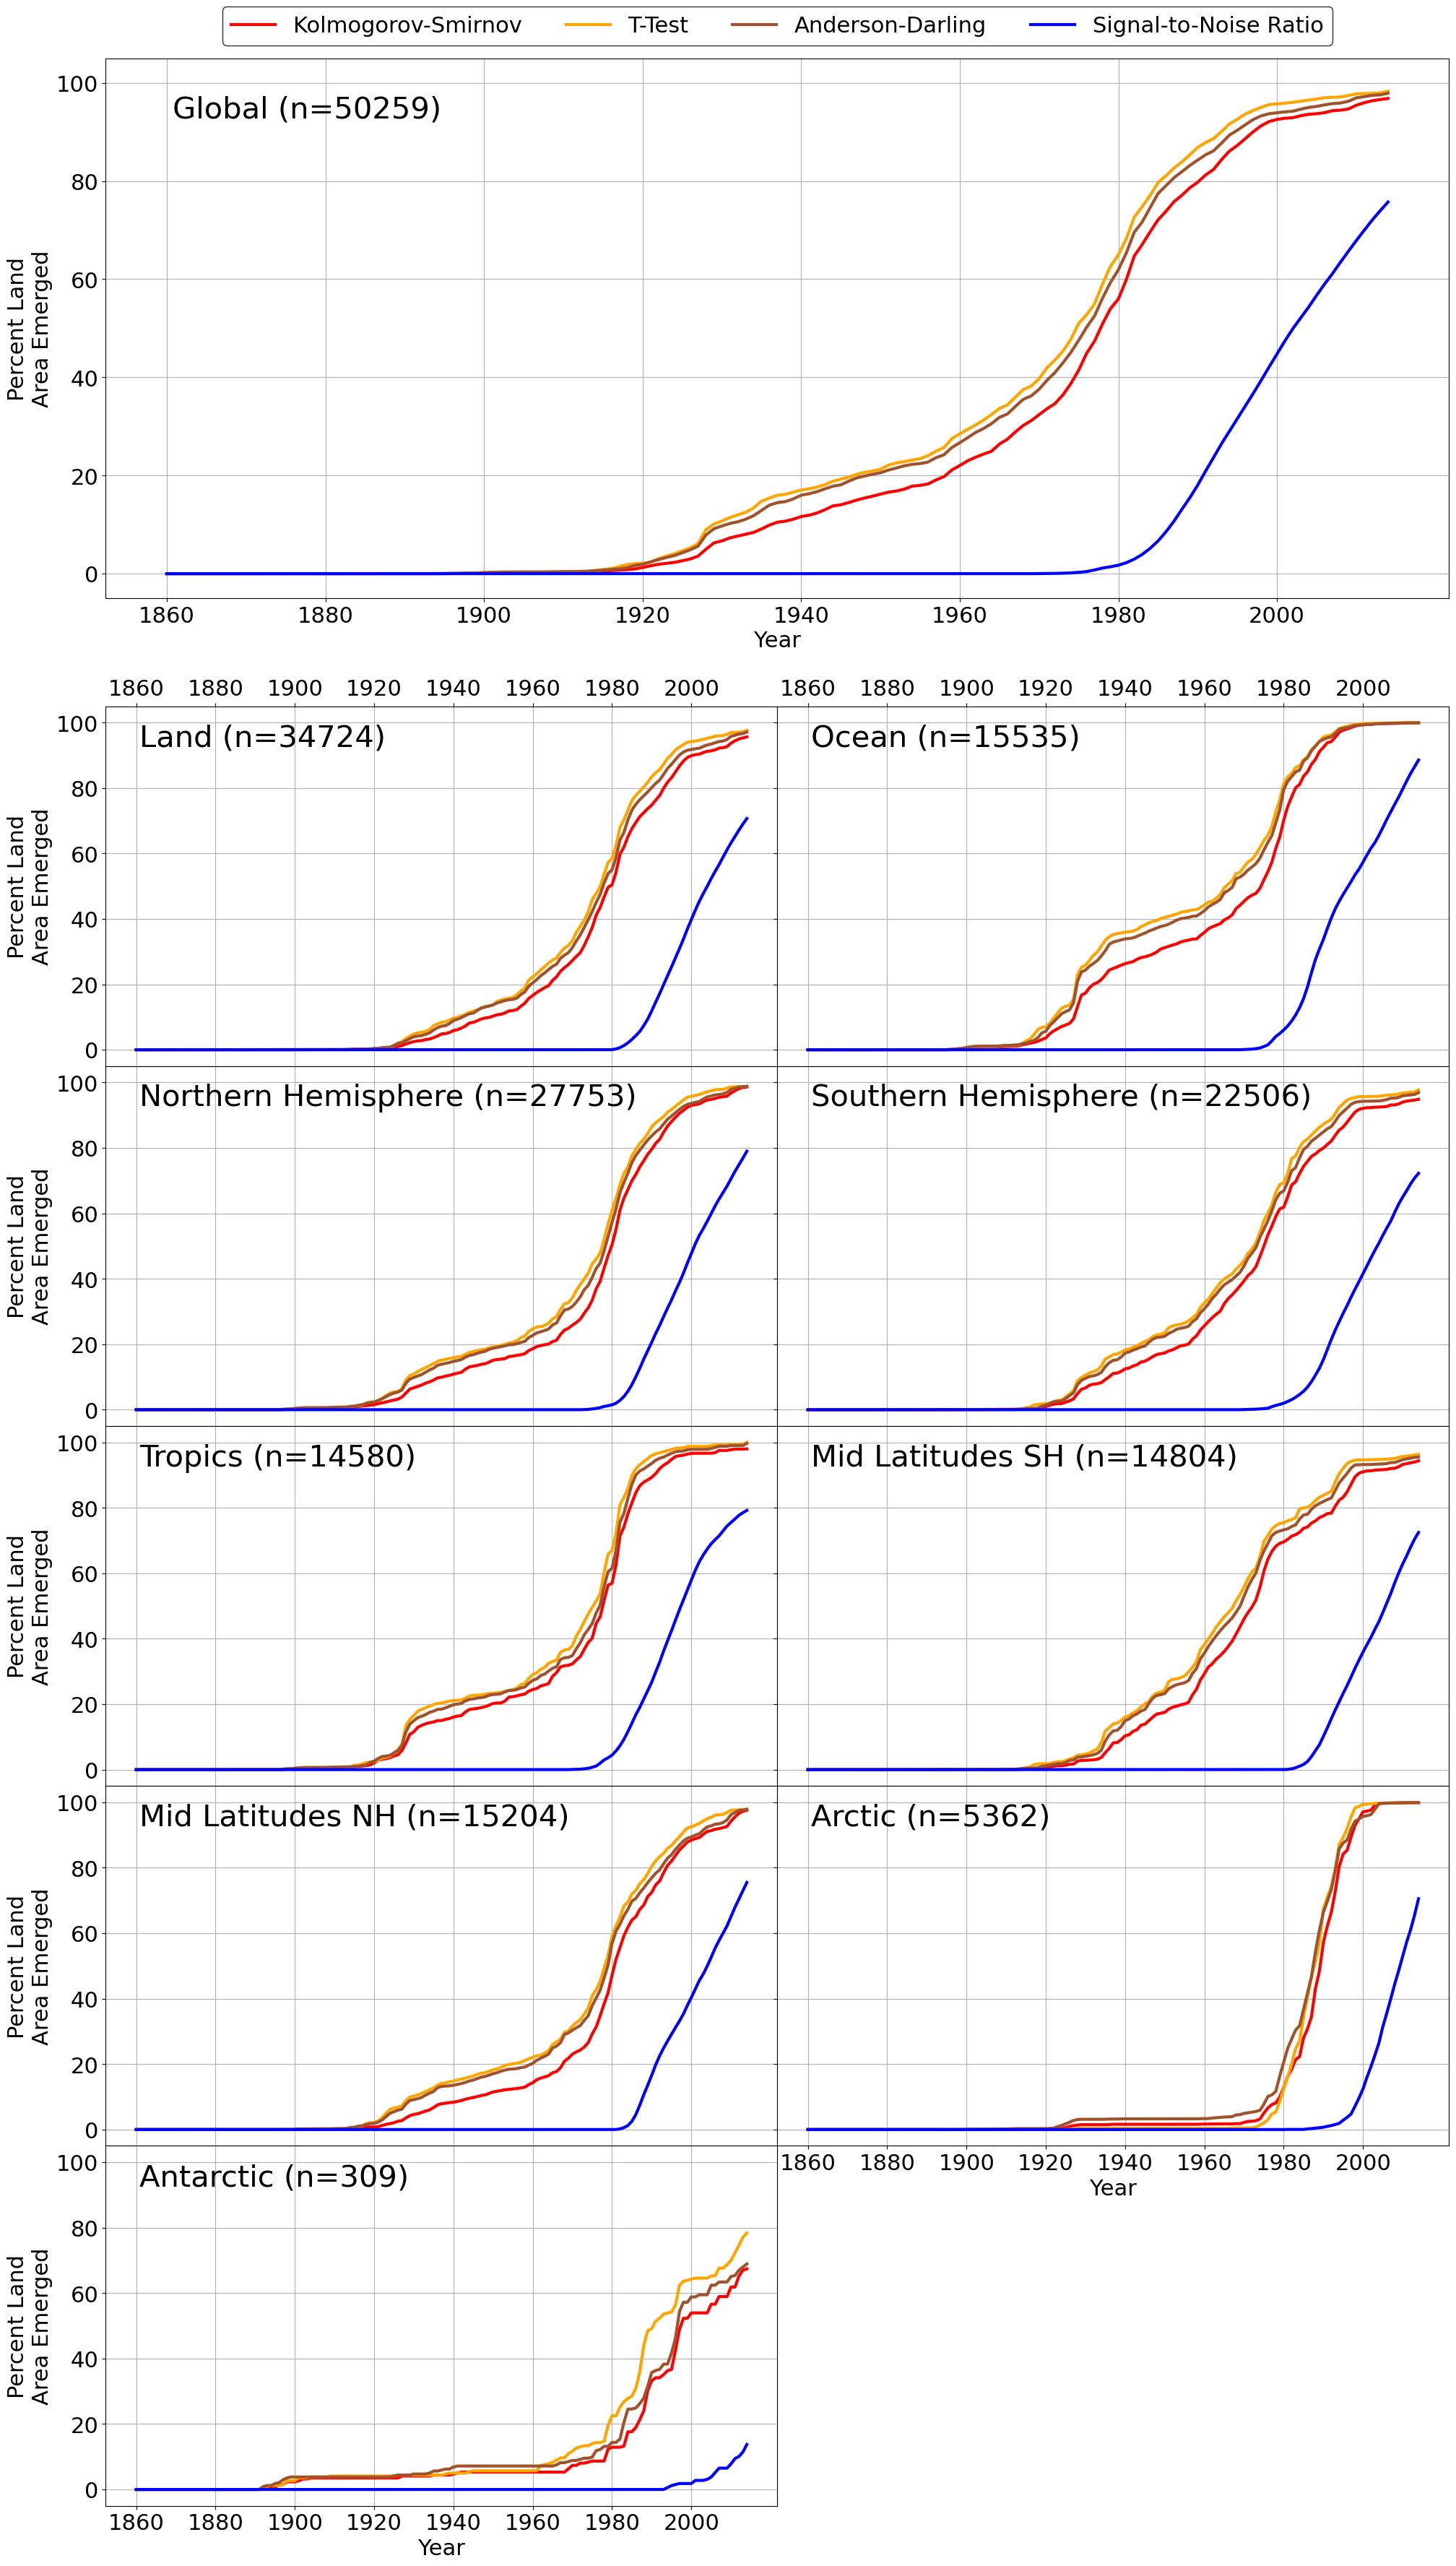

In [127]:
### Plot Creation
nplots = len(emergence_time_series_ds.region.values)+1
fig = plt.figure(figsize=(12*2, 4*nplots))
gs = gridspec.GridSpec(int(np.ceil(nplots/2))+1, 2, height_ratios=[1.5]+[0.3] + [1]*int(np.ceil((nplots-2)/2)), wspace=0, hspace=0)
ax0 = fig.add_subplot(gs[0, :]); axes = [fig.add_subplot(gs[i+4]) for i in range(nplots-2)]
axes.insert(0, ax0)

time = emergence_time_series_ds.time.values

for num, region in enumerate(emergence_time_series_ds.region.values):
    ax=axes[num]
    kwargs_to_use ={}#left_kwargs if ((num%2) or (num==0)) else {}
    # for region in regions:
    region_emergence_ds = emergence_time_series_ds.sel(region=region)
    for test in list(region_emergence_ds.data_vars):
        color = time_of_emergence_plots.TEST_PLOT_DICT.get(test, {}).get('color', 'red')
        label = toe_const.NAME_CONVERSION_DICT.get(test, '')
        ax.plot(time, region_emergence_ds[test].values, color=color, label=label, linewidth=3)
    ax.grid()
    ax.tick_params(axis='y', labelsize=22)
    ax.tick_params(axis='x', labelsize=22)
    number_of_points = int(emergence_time_series_ds.attrs[region]['available'])
    ax.annotate(toe_const.NAMING_MAP.get(region, region) + f' (n={number_of_points})', xy=(0.05, 0.89), size=30, xycoords='axes fraction')

    ax.set_yticks(np.arange(0, 120, 20))#np.take(ax.get_yticks(), np.arange(1, len(ax.get_yticks())-1)))
    ax.set_ylim(-5, 105)

    # Mticker seems to be broken. Not returning the correct year at the correct points

    # Ticks every 20 years
    # Getting just the locations where the year is divisible by 10 with no remainder.
    # Then getting every second one/
    tick_locations = list(filter(lambda t: t.year % 10 == 0, time))[::2]
    ax.set_xticks(tick_locations)
    ax.set_xticklabels(list(map(lambda t:t.year, tick_locations)))

    
    #ax.xaxis.set_major_locator(mdates.YearLocator(base=20))
    #ax.xaxis.set_minor_locator(mdates.YearLocator(base=10))
    #ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

    if num in [1,2]:
        print(region)
        ax.xaxis.tick_top()
    
    if not num%2 and num >1:
        ax.set_yticklabels([])
        ax.set_ylabel('')
    else: ax.set_ylabel('Percent Land\nArea Emerged', fontsize=22)

    if 2 < num < 8: ax.set_xticklabels([]) # Need or the last number can still be seen
    else: ax.set_xlabel('Year', fontsize=22)

# Create the legend
legend = axes[0].legend(ncol=4, loc='center', bbox_to_anchor=(0.5, 1.06), frameon=True, fontsize=22)
frame = legend.get_frame()
frame.set_color('white')  # Set the legend frame color to white
frame.set_edgecolor('black')  # Set the legend frame edge color to black


## SN at KS emergence

In [128]:
sn_at_ks_emergence_ds.median()

<xarray.DataArray ()>
array(0.97)

Text(0.5, 0, 'Signal-to-Noise Ratio')

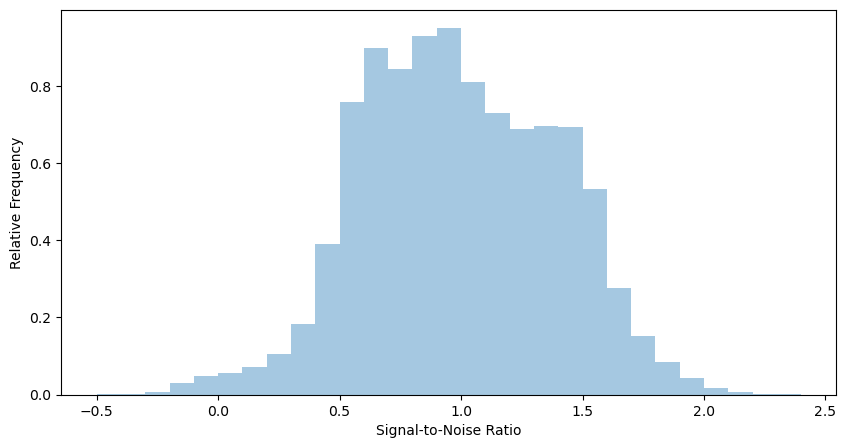

In [129]:
# Histogram of the signal-to-noise values at with the p-value for the KS test emerges
fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(sn_at_ks_emergence_ds.values.flatten(), bins=np.arange(-0.5, 2.5, .1), alpha=0.4, density=True);
ax.set_ylabel('Relative Frequency')
ax.set_xlabel('Signal-to-Noise Ratio')
# ax.tick_params(axis='x', ticksize=12)

In [130]:
not_stable_kwargs3 = {'cmap':cmap_binary, 'add_colorbar':False}

In [131]:
toe_metrics_ds.signal_to_noise.min()

<xarray.DataArray 'signal_to_noise' ()>
array(-2.47)

In [132]:
min_lat_lon_sn_at_kas =\
    utils.find_nth_extreme_location(sn_at_ks_emergence_ds, 'min',output_dtype='dict')
min_lat_lon_sn_at_kas

{'lat': 73.5, 'lon': 107.5}

In [133]:
max_lat_lon_sn_at_kas =\
    utils.find_nth_extreme_location(sn_at_ks_emergence_ds, 'max',output_dtype='dict')
max_lat_lon_sn_at_kas

{'lat': 23.5, 'lon': 46.5}

Text(0.5, 1.0, "{'lat': 23.5, 'lon': 46.5}")

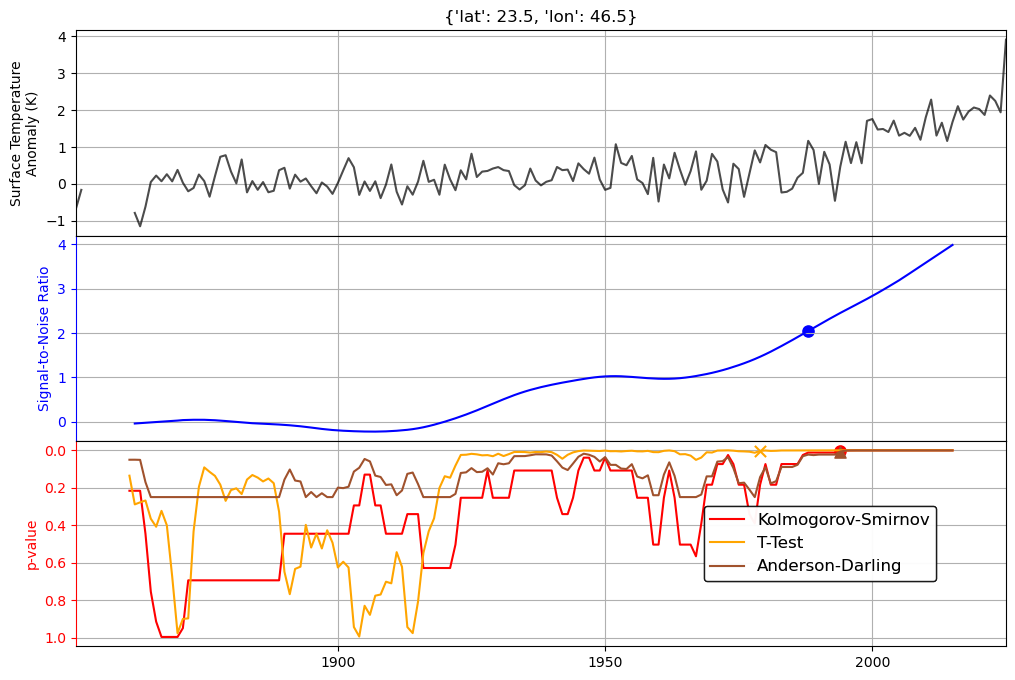

In [134]:
fig, gs, axes = time_of_emergence_plots.plot_multiseries_with_pvalues(toe_metrics_ds.sel(**max_lat_lon_sn_at_kas, method='nearest'),
                              toe_ds.sel(**max_lat_lon_sn_at_kas, method='nearest'),
                              best_ds.sel(**max_lat_lon_sn_at_kas, method='nearest'), return_figure=True)
axes[0].set_title(max_lat_lon_sn_at_kas)

In [135]:
# Veriftying for a single point
signal_sp2, noise_series_sp2, reocnstructed_sp2 =\
    toe.return_hawkins_signal_and_noise(
        best_ds.sel(max_lat_lon_sn_at_kas, method='nearest').values,
         gt=best_ds_smean_lowess.values,
        return_reconstruction=True)

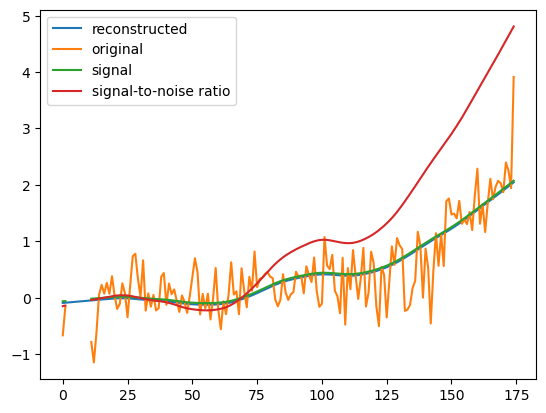

In [136]:
plt.plot(reocnstructed_sp2, label='reconstructed')
plt.plot(best_ds.sel(max_lat_lon_sn_at_kas, method='nearest').values, label='original')
plt.plot(signal_sp2, label='signal')
plt.plot(signal_sp2/np.nanstd(noise_series_sp2), label='signal-to-noise ratio')
plt.legend()

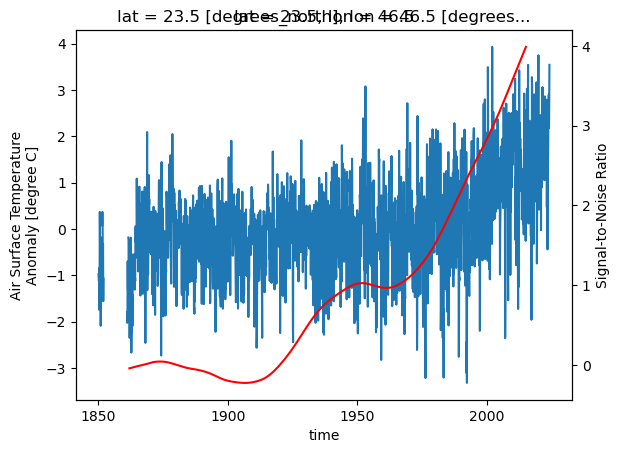

In [137]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
best_ds_raw.temperature.sel(max_lat_lon_sn_at_kas, method='nearest').plot(ax=ax)
toe_metrics_ds.signal_to_noise.sel(max_lat_lon_sn_at_kas, method='nearest').plot(ax=ax2, color='red')

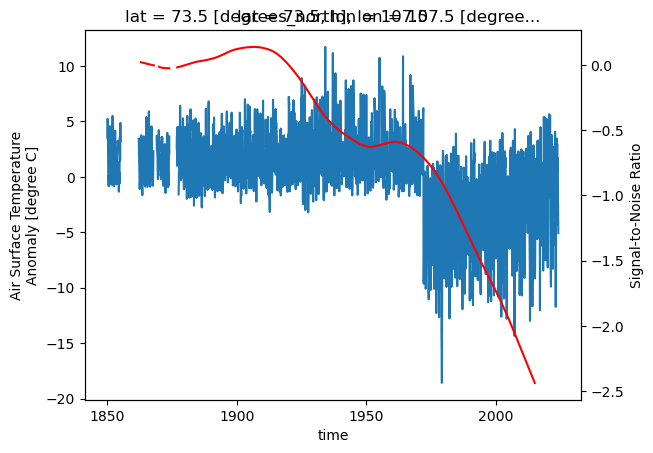

In [138]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
best_ds_raw.temperature.sel(min_lat_lon_sn_at_kas, method='nearest').plot(ax=ax)
toe_metrics_ds.signal_to_noise.sel(min_lat_lon_sn_at_kas, method='nearest').plot(ax=ax2, color='red')

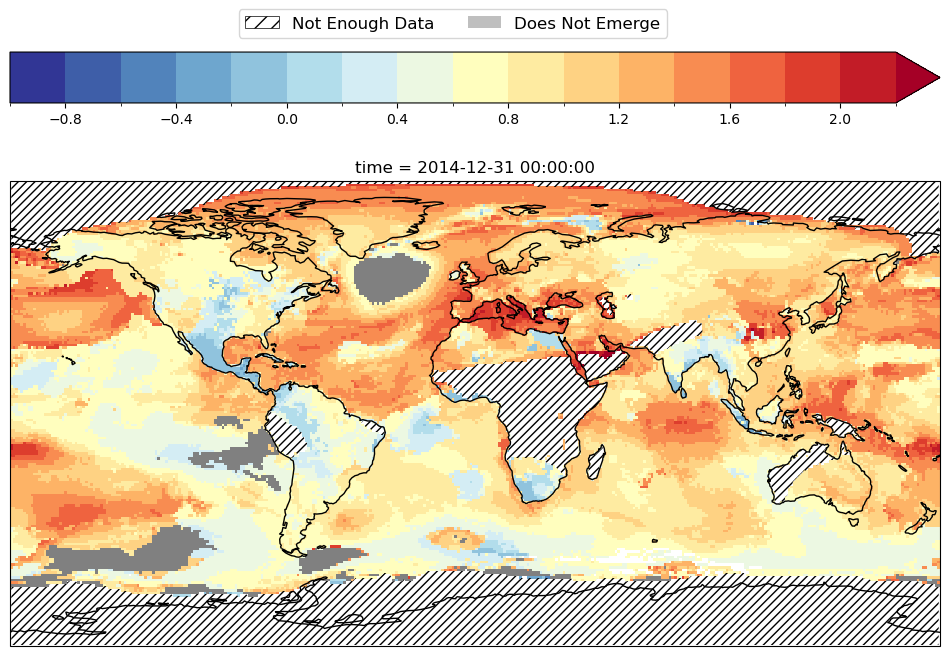

In [139]:
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[0.1, 1])
ax =fig.add_subplot(gs[1], projection=ccrs.PlateCarree())

toe_plot = sn_at_ks_emergence_ds.plot(ax=ax, robust=True, cmap='RdYlBu_r', 
                                      add_colorbar=False, levels=np.arange(-1, 2.4, .2))
hatch(ax, data_unavailability_mask, **not_stable_kwargs)
does_not_emerge_ds['ks'].plot(**not_stable_kwargs3)

cbar_axes1 = plt.subplot(gs[0])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='horizontal')

# Add a legend for both the hatching and "Does Not Emerge"
legend_elements = [
    plt.Rectangle([0, 0], 1, 1, fc='white', hatch='//', edgecolor='black', lw=0.5),
    plt.Rectangle([0, 0], 1, 1, fc='grey', alpha=0.5)  # Gray for "Does Not Emerge"
]
legend_labels = ['Not Enough Data', 'Does Not Emerge']
legend = cbar_axes1.legend(legend_elements, legend_labels, loc='upper center',
                           bbox_to_anchor=(0.5, 2), fontsize='large', ncol=2)
ax.coastlines()

In [140]:
import matplotlib as mpl
import matplotlib.colors as mcolors

In [141]:
lower_levels = np.arange(-.4, 0.1, 0.2) 
middle_levels = np.arange(0, 1.2, 0.2)
upper_levels = np.arange(1, 2.2, 0.2)
levels = np.unique(np.concatenate([lower_levels, middle_levels,upper_levels]))

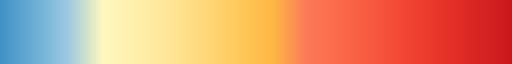

In [142]:
# This is a complex colorbar creation.
# There are three colormaps, and I wan't to select different parts of them.
# THis is as I want a different colormap for all of the different levels above.

base_cmap1 = 'Blues_r'
base_cmap2 = 'YlOrBr'
base_cmap3 = 'Reds'

color_list_lower = plt.get_cmap(base_cmap1)(np.linspace(0, 1, len(lower_levels)*3))
color_list_lower = color_list_lower[int(len(color_list_lower)/3):int(len(color_list_lower)*2/3)]

color_list_middle = plt.get_cmap(base_cmap2)(np.linspace(0, 1, len(middle_levels)*3))
color_list_middle = color_list_middle[int(len(color_list_middle)*1/9):int(len(color_list_middle)*4/9)]

color_list_upper = plt.get_cmap(base_cmap3)(np.linspace(0, 1, len(upper_levels)*3))
color_list_upper = color_list_upper[int(len(color_list_upper)*4/9):int(len(color_list_upper)*7/9)]

# Mergine all the colours together
full_colorlist = np.concatenate([color_list_lower, color_list_middle, color_list_upper])
my_cmap = mcolors.LinearSegmentedColormap.from_list("my_cmap",  full_colorlist)
my_cmap

Text(0.5, 1.0, '')

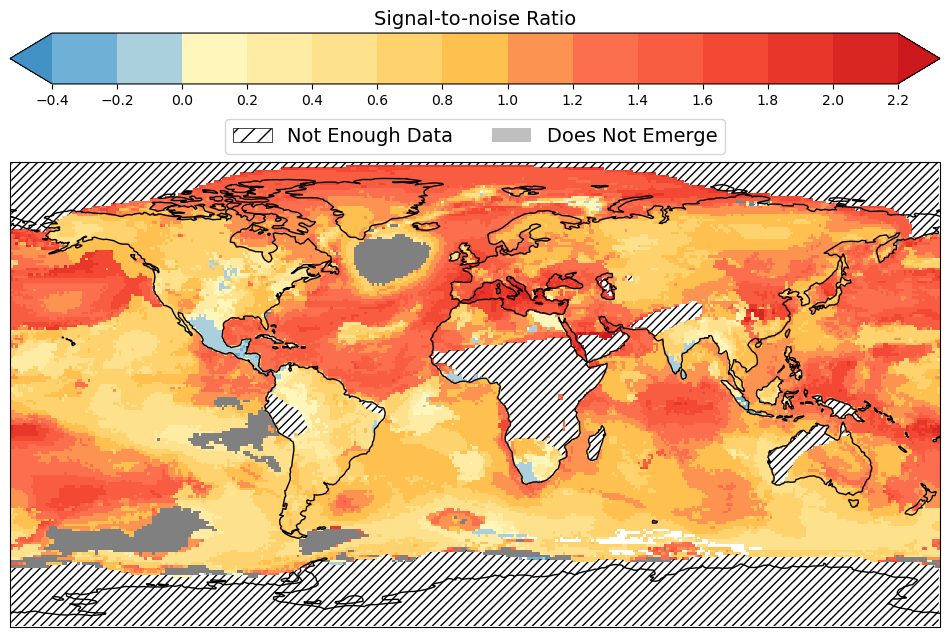

In [143]:
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[0.1, 1])
ax = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())

toe_plot = sn_at_ks_emergence_ds.plot(ax=ax, robust=True, cmap=my_cmap, 
                                      add_colorbar=False, levels=levels)
hatch(ax, data_unavailability_mask, **not_stable_kwargs)
does_not_emerge_ds['ks'].plot(**not_stable_kwargs3)

cbar_axes1 = plt.subplot(gs[0])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='horizontal')
cbar1.ax.set_title('Signal-to-noise Ratio', fontsize=14)
cbar1.ax.set_xticks(levels)
# Add a legend for both the hatching and "Does Not Emerge"
legend_elements = [
    plt.Rectangle([0, 0], 1, 1, fc='white', hatch='//', edgecolor='black', lw=0.5),
    plt.Rectangle([0, 0], 1, 1, fc='grey', alpha=0.5)  # Gray for "Does Not Emerge"
]
legend_labels = ['Not Enough Data', 'Does Not Emerge']
legend = cbar_axes1.legend(legend_elements, legend_labels, loc='upper center',bbox_to_anchor=(0.5, -0.5), fontsize=14, ncol=2)
ax.coastlines()
ax.set_title('')

In [144]:
lower_levels = np.arange(-.4, 0.1, 0.2) 
middle_levels = np.arange(0, 1.2, 0.2)
upper_levels = np.arange(1, 2, 0.2)
extreme_levels = np.arange(2,2.4, 0.2)
levels = np.unique(np.concatenate([lower_levels, middle_levels,upper_levels, extreme_levels]))
levels

array([-0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,
        1.8,  2. ,  2.2])

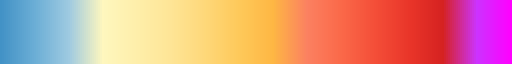

In [145]:
# This is a complex colorbar creation.
# There are three colormaps, and I wan't to select different parts of them.
# THis is as I want a different colormap for all of the different levels above.

base_cmap1 = 'Blues_r'
base_cmap2 = 'YlOrBr'
base_cmap3 = 'Reds'
base_cmap4 = 'cool'


color_list_lower = plt.get_cmap(base_cmap1)(np.linspace(0, 1, len(lower_levels)*3))
color_list_lower = color_list_lower[int(len(color_list_lower)/3):int(len(color_list_lower)*2/3)]

color_list_middle = plt.get_cmap(base_cmap2)(np.linspace(0, 1, len(middle_levels)*3))
color_list_middle = color_list_middle[int(len(color_list_middle)*1/9):int(len(color_list_middle)*4/9)]

color_list_upper = plt.get_cmap(base_cmap3)(np.linspace(0, 1, len(upper_levels)*3))
color_list_upper = color_list_upper[int(len(color_list_upper)*4/9):int(len(color_list_upper)*7/9)]

color_list_extreme = plt.get_cmap(base_cmap4)(np.linspace(0, 1, len(extreme_levels)*3))
color_list_extreme = color_list_extreme[int(len(color_list_extreme)*6/9):int(len(color_list_extreme)*9/9)]

# Mergine all the colours together
full_colorlist = np.concatenate([color_list_lower, color_list_middle, color_list_upper, color_list_extreme])
my_cmap = mcolors.LinearSegmentedColormap.from_list("my_cmap",  full_colorlist)
my_cmap

Text(0.5, 1.0, '')

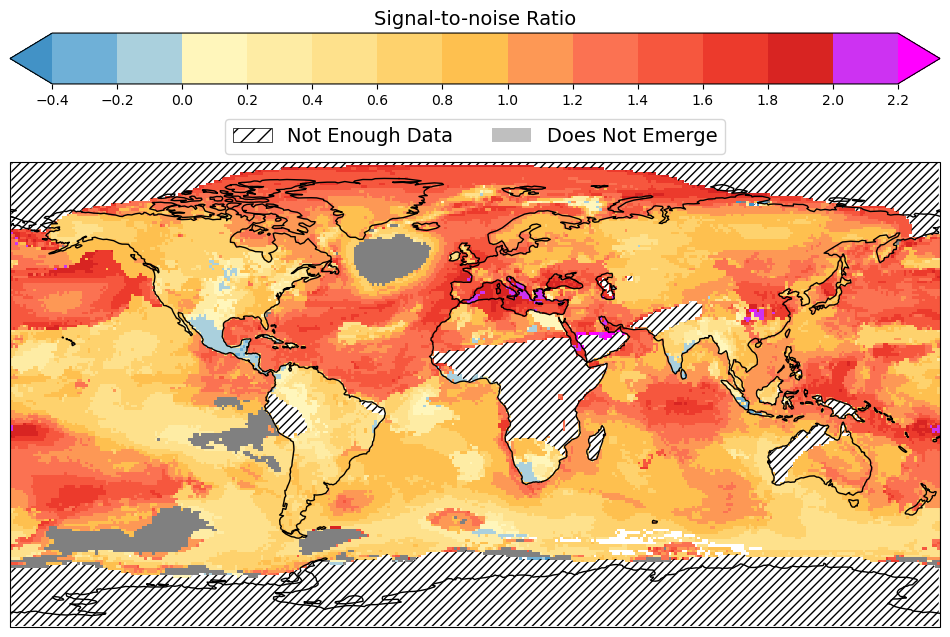

In [146]:
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(2, 1, height_ratios=[0.1, 1])
ax = fig.add_subplot(gs[1], projection=ccrs.PlateCarree())

toe_plot = sn_at_ks_emergence_ds.plot(ax=ax, robust=True, cmap=my_cmap, 
                                      add_colorbar=False, levels=levels)
hatch(ax, data_unavailability_mask, **not_stable_kwargs)
does_not_emerge_ds['ks'].plot(**not_stable_kwargs3)

cbar_axes1 = plt.subplot(gs[0])
cbar1 = plt.colorbar(toe_plot, cax=cbar_axes1, orientation='horizontal')
cbar1.ax.set_title('Signal-to-noise Ratio', fontsize=14)
cbar1.ax.set_xticks(levels)
# Add a legend for both the hatching and "Does Not Emerge"
legend_elements = [
    plt.Rectangle([0, 0], 1, 1, fc='white', hatch='//', edgecolor='black', lw=0.5),
    plt.Rectangle([0, 0], 1, 1, fc='grey', alpha=0.5)  # Gray for "Does Not Emerge"
]
legend_labels = ['Not Enough Data', 'Does Not Emerge']
legend = cbar_axes1.legend(legend_elements, legend_labels, loc='upper center',bbox_to_anchor=(0.5, -0.5), fontsize=14, ncol=2)
ax.coastlines()
ax.set_title('')